In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from collections import Counter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# INITIALISATION

## IMPORT DATA

In [2]:
DATA_PATH = "data/"

In [3]:
data = pd.read_csv('dpe-v2-logements-existants_Q4-24.csv')
data.head()

<ipython-input-3-aceadbf9f10a>:1: DtypeWarning: Columns (11,102,112,190,191,192,193,226,237) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dpe-v2-logements-existants_Q4-24.csv')


,N°DPE,Date_réception_DPE,Date_établissement_DPE,Date_visite_diagnostiqueur,Modèle_DPE,N°_DPE_remplacé,Date_fin_validité_DPE,Version_DPE,N°_DPE_immeuble_associé,Appartement_non_visité_(0/1),...,Type_générateur_froid,Surface_climatisée,Type_énergie_climatisation,Catégorie_ENR,Electricité_PV_autoconsommée,Système_production_électricité_origine_renouvelable,Présence_production_PV_(0/1),Production_électricité_PV_(kWhep/an),Surface_totale_capteurs_photovoltaïque,Nombre_module
0,2427E4057431F,2024-11-18,2024-11-17,2024-11-17,DPE 3CL 2021 méthode logement,NaN,2034-11-16,2.4,NaN,NaN,...,NaN,NaN,NaN,panneaux solaires photovoltaïques,NaN,Solaire Photovoltaïque,1.0,10416.9,28.8,24.0
1,2462E3922466P,2024-11-06,2024-11-05,2024-10-30,DPE 3CL 2021 méthode logement,NaN,2034-11-04,2.4,NaN,NaN,...,NaN,NaN,NaN,panneaux solaires photovoltaïques,NaN,Solaire Photovoltaïque,1.0,4683.3,10.8,9.0
2,2481E3633888E,2024-10-16,2024-10-15,2024-10-10,DPE 3CL 2021 méthode logement,NaN,2034-10-14,2.4,NaN,NaN,...,PAC air/air installée entre 2008 et 2014,65.5,Électricité,Il existe plusieurs descriptifs ENR,NaN,Solaire Photovoltaïque,1.0,4658.2,16.0,1.0
3,2433E3834950M,2024-10-30,2024-10-29,2024-10-21,DPE 3CL 2021 méthode logement,2333E1163577I,2034-10-28,2.4,NaN,NaN,...,PAC air/air installée avant 2008,285.0,Électricité,Il existe plusieurs descriptifs ENR,NaN,Solaire Photovoltaïque,1.0,11223.0,24.0,20.0
4,2464E3951206B,2024-11-08,2024-11-07,2024-11-06,DPE 3CL 2021 méthode logement,NaN,2034-11-06,2.4,NaN,NaN,...,NaN,NaN,NaN,panneaux solaires photovoltaïques,NaN,Solaire Photovoltaïque,1.0,7628.7,16.8,14.0


## EXPLORATION VARIABLE CIBLE

In [4]:
data.rename(columns={"Conso_5_usages/m²_é_finale": "conso_nrj_m2_par_an"}, inplace=True)

In [5]:
y = data["conso_nrj_m2_par_an"]
y.head(10)

,conso_nrj_m2_par_an
0,216.0
1,73.0
2,137.8
3,56.0
4,136.0
5,52.0
6,52.0
7,58.0
8,47.0
9,220.0


In [6]:
y.describe()

,conso_nrj_m2_par_an
count,129597.000000
mean,163.188868
std,100.106938
min,6.000000
25%,95.000000
50%,137.000000
75%,210.000000
max,2636.000000


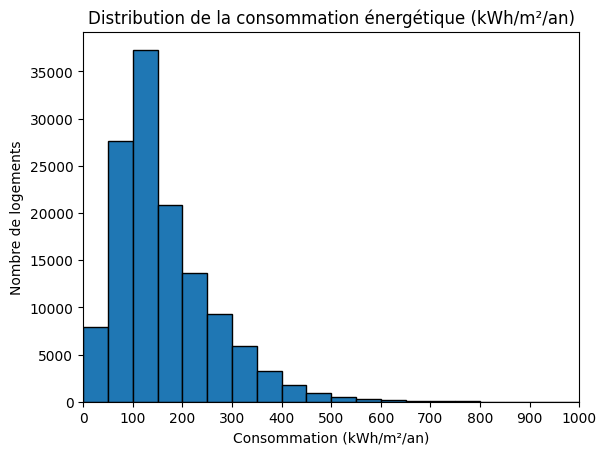

In [7]:
# Visu de la consommation moyenne des Français par m2/an (161 kWh en 2022)
plt.hist(y.dropna(), bins=range(0, 1050, 50), edgecolor="k")
plt.title("Distribution de la consommation énergétique (kWh/m²/an)")
plt.xlabel("Consommation (kWh/m²/an)")
plt.ylabel("Nombre de logements")
plt.xlim(0, 1000)
plt.xticks(range(0, 1100, 100))
plt.show()

## EDA GENERAL (CODE MATHIEU)

### TYPE OF DATA

In [8]:
"""
On classe les colonnes en fonction de leur type
"""

data_type = data

column_classification = {
    "Quantitative_Continues": [],
    "Quantitative_Discretes": [],
    "Qualitative_Nominales": [],
    "Qualitative_Ordinales": [],
    "Binaires": [],
    "Dates": []
}

# Ensembles de référence pour détecter les colonnes ordinales
known_ordinal_sets = [
    ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
    ['faible', 'moyen', 'élevé'],
    ['insuffisante', 'moyenne', 'bonne'],
    ['Lourde', 'Moyenne', 'Légère']
]

# Parcourir les colonnes pour les classifier automatiquement
for col in data_type.columns:
    # Ignorer les colonnes entièrement vides
    if data_type[col].isnull().all():
        continue

    unique_values = data_type[col].dropna().unique()
    num_unique = len(unique_values)

    # Vérifier si c'est une colonne binaire (0 ou 1 uniquement)
    if set(unique_values).issubset({0, 1}):
        column_classification["Binaires"].append(col)

    # Vérifier si c'est une colonne temporelle (date)
    elif pd.api.types.is_datetime64_any_dtype(data_type[col]) or "Date" in col or "Période" in col:
        column_classification["Dates"].append(col)

    # Vérifier si c'est une variable quantitative discrète ou continue
    elif pd.api.types.is_numeric_dtype(data_type[col]):
        # Vérifier si toutes les valeurs sont des entiers (même si float64)
        all_integers = all(float(val).is_integer() for val in unique_values)

        if num_unique < 10000 and all_integers:
            column_classification["Quantitative_Discretes"].append(col)
        else:
            column_classification["Quantitative_Continues"].append(col)

    # Vérifier si c'est une variable qualitative ordinale
    elif pd.api.types.is_string_dtype(data_type[col]) or num_unique < 50:  # Heuristique pour catégorisation
        # Vérifier si toutes les valeurs uniques sont dans un ensemble de référence
        is_ordinal = False
        for ordinal_set in known_ordinal_sets:
            if any(val in ordinal_set for val in unique_values):
                column_classification["Qualitative_Ordinales"].append(col)
                is_ordinal = True
                break
        # Si ce n'est pas ordinale, l'ajouter comme nominale
        if not is_ordinal:
            column_classification["Qualitative_Nominales"].append(col)

    # Parcourir les colonnes restantes non classées
    classified_columns = (
        column_classification["Quantitative_Continues"] +
        column_classification["Quantitative_Discretes"] +
        column_classification["Qualitative_Nominales"] +
        column_classification["Qualitative_Ordinales"] +
        column_classification["Binaires"] +
        column_classification["Dates"]
    )

for col in data_type.columns:
    if col not in classified_columns:
        # Classer les colonnes non classées comme nominales
        column_classification["Qualitative_Nominales"].append(col)

# Afficher les résultats
for key, cols in column_classification.items():
    print(f"{key}:")
    for idx, col in enumerate(cols):
        col_index = data_type.columns.get_loc(col)
        print(f"  {col_index}: {col}")


Quantitative_Continues:
  7: Version_DPE
  21: Hauteur_sous-plafond
  26: Surface_habitable_logement
  40: Score_BAN
  42: Coordonnée_cartographique_X_(BAN)
  43: Coordonnée_cartographique_Y_(BAN)
  53: Conso_5_usages_é_finale
  54: conso_nrj_m2_par_an
  55: Conso_chauffage_é_finale
  56: Conso_chauffage_dépensier_é_finale
  57: Conso_éclairage_é_finale
  58: Conso_ECS_é_finale
  59: Conso_ECS_dépensier_é_finale
  60: Conso_refroidissement_é_finale
  61: Conso_refroidissement_dépensier_é_finale
  62: Conso_auxiliaires_é_finale
  63: Conso_5_usages_é_primaire
  64: Conso_5_usages_par_m²_é_primaire
  65: Conso_chauffage_é_primaire
  66: Conso_chauffage_dépensier_é_primaire
  67: Conso_éclairage_é_primaire
  68: Conso_ECS_é_primaire
  69: Conso_ECS_dépensier_é_primaire
  70: Conso_refroidissement_é_primaire
  71: Conso_refroidissement_dépensier_é_primaire
  72: Conso_auxiliaires_é_primaire
  73: Emission_GES_5_usages
  74: Emission_GES_5_usages_par_m²
  75: Emission_GES_chauffage
  76: Em

### MISSING VALUES

In [9]:
# Résumé des valeurs manquantes pour chaque colonne
missing_summary = data.isnull().sum().reset_index()
missing_summary.columns = ["Column", "Missing Values"]
missing_summary["Missing Percentage"] = (missing_summary["Missing Values"] / len(data)) * 100

# Trier par pourcentage décroissant
missing_summary = missing_summary.sort_values(by="Missing Percentage", ascending=False)

# Configurer pandas pour afficher toutes les colonnes
pd.set_option('display.max_rows', None)  # Afficher toutes les lignes
pd.set_option('display.max_columns', None)  # Afficher toutes les colonnes

# Afficher toutes les colonnes
print(missing_summary)

# Réinitialiser les options si nécessaire
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

                                                Column  Missing Values  \
215                  Conso_é_finale_générateur_ECS_n°2          129597   
223                 Volume_stockage_générateur_ECS_n°2          129597   
222                           Usage_générateur_ECS_n°2          129597   
224                                Besoin_ECS_bâtiment          129597   
225                                Besoin_ECS_logement          129597   
221                            Type_générateur_ECS_n°2          129597   
30                     Position_logement_dans_immeuble          129597   
29                                  Typologie_logement          129597   
220                    Type_énergie_générateur_ECS_n°2          129597   
27                          Surface_tertiaire_immeuble          129597   
219               Date_installation_générateur_ECS_n°2          129597   
25                          Surface_habitable_immeuble          129597   
218                     Description_gé

In [10]:
"""
On s'aperçoit qu'il y a beaucoup de colonnes contenant énormément de valeurs manquantes. Après analyse de ces dernières,
on décide d'enlever les colonnes pour lesquelles le taux de valeurs manquantes est supérieur à 1%
(ces colonnes ne sont de toute façon pas pertinentes pour notre analyse).
"""
# Calculer le pourcentage de valeurs manquantes
missing_percentage = data.isnull().mean() * 100

# Sélectionner les colonnes à conserver (celles avec moins de 1 % de valeurs manquantes)
columns_to_keep = missing_percentage[missing_percentage <= 1].index

# Créer un nouveau DataFrame sans les colonnes avec plus de 1 % de valeurs manquantes
data = data[columns_to_keep]

# Afficher le résultat
print(f"Colonnes conservées : {len(columns_to_keep)}")


Colonnes conservées : 136


In [11]:
"""
Gestion des valeurs manquantes en fonction de leur type
"""

# Quantitative_Continues et Quantitative_Discretes
# On prend la médiane pour ne pas être trop affecté par les outliers
for col in column_classification["Quantitative_Continues"] + column_classification["Quantitative_Discretes"]:
    if col in data.columns:  # Vérifie si la colonne existe
        data.loc[:, col] = data[col].fillna(data[col].median())

# Qualitative_Nominales et Qualitative_Ordinales
# On prend le mode pour remplacer les valeurs manquantes par la valeur la plus fréquente dans le dataset
for col in column_classification["Qualitative_Nominales"] + column_classification["Qualitative_Ordinales"]:
    if col in data.columns:  # Vérifie si la colonne existe
        data.loc[:, col] = data[col].fillna(data[col].mode()[0])

# Binaires
# On enlève les lignes pour lesquelles la valeur est manquante (juste 2 valeurs manquantes pour Isolation_toiture_(0/1))
for col in column_classification["Binaires"]:
    if col in data.columns:  # Vérifie si la colonne existe
        data = data.dropna(subset=[col])

In [12]:
# Vérifie si des valeurs manquantes sont présentes dans le DataFrame
missing_values = data.isnull().sum()

# Affiche uniquement les colonnes avec des valeurs manquantes
missing_report = missing_values[missing_values > 0]

if missing_report.empty:
    print("Aucune valeur manquante dans le DataFrame.")
else:
    print("Colonnes avec des valeurs manquantes :")
    print(missing_report)


Aucune valeur manquante dans le DataFrame.


### VARIABLE TRANSFORMATION

In [13]:
"""
On transforme les variables ordinales
"""

# Définir les mappings spécifiques en fonction du préfixe du nom des colonnes
ordinal_mappings = {
    "Etiquette": {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7},
    "Classe": {'Légère': 1, 'Moyenne': 2, 'Lourde': 3, 'Très lourde': 4},
    "Indicateur": {'bon': 1, 'moyen': 2, 'insuffisant': 3},
    "Qualité": {'très bonne': 1, 'bonne': 2, 'moyenne': 3, 'insuffisante': 4}
}

# Parcourir les colonnes Qualitative_Ordinales
for col in column_classification["Qualitative_Ordinales"]:
    if col in data.columns:
        # Vérifier si le nom de la colonne commence par une clé dans ordinal_mappings
        for prefix, mapping in ordinal_mappings.items():
            if col.startswith(prefix):
                # Appliquer le mapping correspondant
                data[col] = data[col].map(mapping).astype('float')  # Conversion explicite en float
                break  # Passer à la colonne suivante une fois le mapping trouvé


In [14]:
"""
On transforme les variables dates comme une différence par rapport à une date de référence
"""

# Date de référence
date_ref = pd.Timestamp('2025-01-01')

# Mapping des périodes
periode_mapping = {
    'avant 1948': 1947,
    '1948-1974': 1961,
    '1975-1977': 1976,
    '1978-1982': 1980,
    '1983-1988': 1985,
    '1989-2000': 1995,
    '2001-2005': 2003,
    '2006-2012': 2009,
    '2013-2021': 2017,
    'après 2021': 2023
}

# Parcourir les colonnes
for col in column_classification["Dates"]:
    if col in data.columns:  # Vérifie si la colonne existe
        if col.startswith("Date"):
            # Convertir en datetime
            data[col] = pd.to_datetime(data[col], errors='coerce')
            # Vérifier que la colonne est bien de type datetime avant d'utiliser .dt
            if pd.api.types.is_datetime64_any_dtype(data[col]):
                # Calculer la différence en années et remplacer la colonne
                data.loc[:, col] = (date_ref - data[col]).dt.days / 365.25
        elif col.startswith("Période"):
            # Mapper les périodes puis calculer la différence en années
            data.loc[:, col] = data[col].map(periode_mapping)
            # Vérifier que le mapping a réussi
            if data[col].notnull().all():
                data.loc[:, col] = date_ref.year - data[col]


<ipython-input-14-3695314c655b>:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.12046543 0.15331964 0.21081451 ... 0.1779603  0.15879535 0.19164956]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  data.loc[:, col] = (date_ref - data[col]).dt.days / 365.25
<ipython-input-14-3695314c655b>:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.12320329 0.15605749 0.21355236 ... 0.1889117  0.1615332  0.19438741]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  data.loc[:, col] = (date_ref - data[col]).dt.days / 365.25
<ipython-input-14-3695314c655b>:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.12320329 0.1724846  0.22724162 ... 0.1889117  0.1724846  0.19438741]' has d

In [15]:
"""
Après analyse des valeurs uniques pour les types Qualitative_Nominales, nous trouvons pertinent de garder
Classe_altitude et Zone_climatique_
Le reste des colonnes est supprimé.
"""

# Parcourir les colonnes Qualitative_Nominales
for col in column_classification["Qualitative_Nominales"]:
    if col in data.columns:  # Vérifie que la colonne existe dans le DataFrame
        # Vérifier le nombre de valeurs uniques
        num_unique = data[col].nunique()

        # Si le nombre de valeurs uniques est inférieur à 50
        if num_unique < 50:
            # Afficher les valeurs uniques
            print(f"Valeurs uniques pour la colonne '{col}' (moins de 50 valeurs uniques) :")
            print(data[col].unique())
            print(f"Nombre de valeurs uniques : {num_unique}")
            print("-" * 50)

Valeurs uniques pour la colonne 'Modèle_DPE' (moins de 50 valeurs uniques) :
['DPE 3CL 2021 méthode logement']
Nombre de valeurs uniques : 1
--------------------------------------------------
Valeurs uniques pour la colonne 'Méthode_application_DPE' (moins de 50 valeurs uniques) :
['dpe maison individuelle']
Nombre de valeurs uniques : 1
--------------------------------------------------
Valeurs uniques pour la colonne 'Type_bâtiment' (moins de 50 valeurs uniques) :
['maison']
Nombre de valeurs uniques : 1
--------------------------------------------------
Valeurs uniques pour la colonne 'Classe_altitude' (moins de 50 valeurs uniques) :
['inférieur à 400m' '400-800m' 'supérieur à 800m']
Nombre de valeurs uniques : 3
--------------------------------------------------
Valeurs uniques pour la colonne 'Zone_climatique_' (moins de 50 valeurs uniques) :
['H1a' 'H2c' 'H3' 'H1b' 'H2a' 'H1c' 'H2b' 'H2d']
Nombre de valeurs uniques : 8
--------------------------------------------------
Valeurs un

In [16]:
"""
On transforme certaines variables nominales
"""

nominal_mappings = {
    "Classe_altitude": {'inférieur à 400m': 1, '400-800m': 2, 'supérieur à 800m': 3},
}

# Fonction pour transformer les valeurs de Zone_climatique_ selon le préfixe
def map_zone_climatique(value):
    if value.startswith('H3'):
        return 1
    elif value.startswith('H2'):
        return 2
    elif value.startswith('H1'):
        return 3

# Parcourir les colonnes Qualitative_Nominales
for col in column_classification["Qualitative_Nominales"]:
    if col in data.columns:
            if col == "Zone_climatique_":
                data[col] = data[col].apply(map_zone_climatique)  # Appliquer la transformation spécifique
            elif col == "Classe_altitude":
                 for key, mapping in nominal_mappings.items():
                    if col == key:
                        data[col] = data[col].map(mapping).astype('float')  # Transformation en valeurs numériques
                        break
            else:
                data = data.drop(columns=[col])

In [17]:
"""
Récapitulatif des colonnes conservées et de leurs types
"""

# Affichage des colonnes classées par type
for col_type, columns in column_classification.items():
    print(f"{col_type}:")
    for col in columns:
        if col in data.columns:  # Vérifie si la colonne existe toujours
            print(f"  - {col}")
    print()  # Ligne vide pour séparer les types

Quantitative_Continues:
  - Version_DPE
  - Hauteur_sous-plafond
  - Surface_habitable_logement
  - Score_BAN
  - Coordonnée_cartographique_X_(BAN)
  - Coordonnée_cartographique_Y_(BAN)
  - Conso_5_usages_é_finale
  - conso_nrj_m2_par_an
  - Conso_chauffage_é_finale
  - Conso_chauffage_dépensier_é_finale
  - Conso_éclairage_é_finale
  - Conso_ECS_é_finale
  - Conso_ECS_dépensier_é_finale
  - Conso_refroidissement_é_finale
  - Conso_refroidissement_dépensier_é_finale
  - Conso_auxiliaires_é_finale
  - Conso_5_usages_é_primaire
  - Conso_5_usages_par_m²_é_primaire
  - Conso_chauffage_é_primaire
  - Conso_chauffage_dépensier_é_primaire
  - Conso_éclairage_é_primaire
  - Conso_ECS_é_primaire
  - Conso_ECS_dépensier_é_primaire
  - Conso_refroidissement_é_primaire
  - Conso_refroidissement_dépensier_é_primaire
  - Conso_auxiliaires_é_primaire
  - Emission_GES_5_usages
  - Emission_GES_5_usages_par_m²
  - Emission_GES_chauffage
  - Emission_GES_chauffage_dépensier
  - Emission_GES_éclairage
 

### OUTLIERS VARIABLE CIBLE

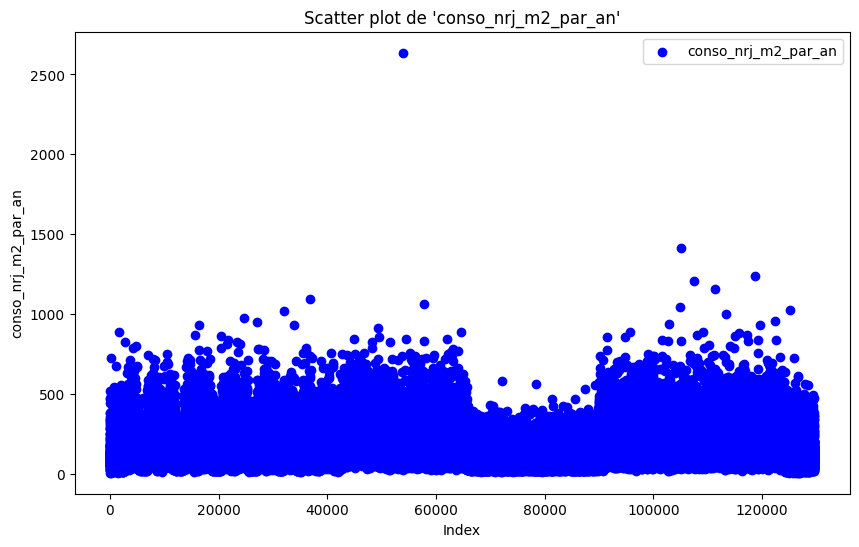

In [18]:
"""
On va détecter les outliers avec la méthode des quantiles.
"""

colonne = "conso_nrj_m2_par_an"

# Visualiser les résultats avec un scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data.index, data[colonne], color='blue', label=colonne)
plt.title(f"Scatter plot de '{colonne}'")
plt.xlabel("Index")
plt.ylabel(colonne)
plt.legend()
plt.show()

In [19]:
# Définir la colonne dynamique
colonne = "conso_nrj_m2_par_an"

# Calculer les quartiles
Q1 = data[colonne].quantile(0.25)
Q3 = data[colonne].quantile(0.75)
IQR = Q3 - Q1

# Définir les bornes pour les outliers
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

# Identifier les outliers
outliers = data[(data[colonne] < lower_bound) | (data[colonne] > upper_bound)]

# Afficher les valeurs des outliers détectés
print("Valeurs des outliers détectés :")
print(outliers[colonne].values)

# Afficher le nombre d'outliers détectés
print(f"Nombre d'outliers détectés : {outliers.shape[0]}")


Valeurs des outliers détectés :
[471.1 518.4 466.8 ... 459.9 490.5 475.7]
Nombre d'outliers détectés : 2325


In [20]:
"""
On enlève les outliers détectés sur notre target variable.
(outliers possibles sur les autres features)
"""

# Supprimer les lignes contenant des outliers
data = data[(data[colonne] >= lower_bound) & (data[colonne] <= upper_bound)]
print(f"Nombre de lignes après suppression des outliers : {data.shape[0]}")

Nombre de lignes après suppression des outliers : 127270


###NORMALISATION

In [21]:
scaler = StandardScaler()
continuous_features = quantitative_continuous_columns = [
    "Version_DPE", "Hauteur_sous-plafond", "Surface_habitable_logement",
    "Score_BAN", "Coordonnée_cartographique_X_(BAN)", "Coordonnée_cartographique_Y_(BAN)",
    "Conso_5_usages_é_finale", "conso_nrj_m2_par_an", "Conso_chauffage_é_finale",
    "Conso_chauffage_dépensier_é_finale", "Conso_éclairage_é_finale",
    "Conso_ECS_é_finale", "Conso_ECS_dépensier_é_finale", "Conso_refroidissement_é_finale",
    "Conso_refroidissement_dépensier_é_finale", "Conso_auxiliaires_é_finale",
    "Conso_5_usages_é_primaire", "Conso_5_usages_par_m²_é_primaire",
    "Conso_chauffage_é_primaire", "Conso_chauffage_dépensier_é_primaire",
    "Conso_éclairage_é_primaire", "Conso_ECS_é_primaire", "Conso_ECS_dépensier_é_primaire",
    "Conso_refroidissement_é_primaire", "Conso_refroidissement_dépensier_é_primaire",
    "Conso_auxiliaires_é_primaire", "Emission_GES_5_usages", "Emission_GES_5_usages_par_m²",
    "Emission_GES_chauffage", "Emission_GES_chauffage_dépensier", "Emission_GES_éclairage",
    "Emission_GES_ECS", "Emission_GES_ECS_dépensier", "Emission_GES_refroidissement",
    "Emission_GES_refroidissement_dépensier", "Emission_GES_auxiliaires",
    "Conso_5_usages_é_finale_énergie_n°1", "Conso_chauffage_é_finale_énergie_n°1",
    "Conso_ECS_é_finale_énergie_n°1", "Coût_total_5_usages_énergie_n°1",
    "Coût_chauffage_énergie_n°1", "Coût_ECS_énergie_n°1", "Emission_GES_5_usages_énergie_n°1",
    "Emission_GES_chauffage_énergie_n°1", "Emission_GES_ECS_énergie_n°1",
    "Coût_total_5_usages", "Coût_chauffage", "Coût_chauffage_dépensier",
    "Coût_éclairage", "Coût_ECS", "Coût_ECS_dépensier", "Coût_refroidissement",
    "Coût_refroidissement_dépensier", "Coût_auxiliaires", "Deperditions_baies_vitrées",
    "Deperditions_enveloppe", "Déperditions_murs", "Deperditions_planchers_bas",
    "Deperditions_planchers_hauts", "Déperditions_ponts_thermiques", "Déperditions_portes",
    "Déperditions_renouvellement_air", "Ubat_W/m²_K", "Apports_internes_saison_chauffe_",
    "Apports_internes_saison_froid", "Apports_solaires_saison_chauffe",
    "Apports_solaires_saison_froid", "Besoin_chauffage", "Besoin_refroidissement_dépensier",
    "Conso_chauffage_installation_chauffage_n°1", "Conso_chauffage_dépensier_installation_chauffage_n°1",
    "Surface_chauffée_installation_chauffage_n°1", "Conso_chauffage_générateur_n°1_installation_n°1",
    "Conso_chauffage_dépensier_générateur_n°1_installation_n°1", "Conso_é_finale_installation_ECS",
    "Conso_é_finale_dépensier_installation_ECS", "Surface_habitable_desservie_par_installation_ECS",
    "Conso_é_finale_générateur_ECS_n°1", "Conso_é_finale_dépensier_générateur_ECS_n°1",
    "Volume_stockage_générateur_ECS_n°1", "Production_électricité_PV_(kWhep/an)",'Etiquette_GES', 'Etiquette_DPE', 'Classe_inertie_bâtiment',
    'Indicateur_confort_été', 'Qualité_isolation_enveloppe',
    'Qualité_isolation_menuiseries', 'Qualité_isolation_murs',
    'Qualité_isolation_plancher_bas'
]
data[continuous_features] = scaler.fit_transform(data[continuous_features])

### CORRELATION

In [22]:
# CLASSEMENT DES CORRELATIONS DES VARIABLES AVEC Y

# Définir la colonne target y
y = "conso_nrj_m2_par_an"

# Filtrer les colonnes pertinentes dans le DataFrame
data_for_corr = data[data.columns]

# Calculer la matrice de corrélation
correlation_matrix = data_for_corr.corr()

# Extraire les corrélations avec la variable cible 'y'
correlations_with_y = correlation_matrix[y].drop(y)  # Exclure la corrélation de 'y' avec elle-même

# Définir des seuils pour les différentes forces de corrélation
thresholds = {
    'Modérée': 0.4,
    'Forte': 0.6,
    'Très forte': 0.8
}

# Créer des listes pour chaque catégorie de corrélation
moderate_correlations = correlations_with_y[(correlations_with_y.abs() > thresholds['Modérée']) & (correlations_with_y.abs() <= thresholds['Forte'])]
strong_correlations = correlations_with_y[(correlations_with_y.abs() > thresholds['Forte']) & (correlations_with_y.abs() <= thresholds['Très forte'])]
very_strong_correlations = correlations_with_y[correlations_with_y.abs() > thresholds['Très forte']]

# Afficher les résultats
print("Colonnes avec une corrélation modérée avec la variable cible y:")
print(moderate_correlations)

print("\nColonnes avec une corrélation forte avec la variable cible y:")
print(strong_correlations)

print("\nColonnes avec une corrélation très forte avec la variable cible y:")
print(very_strong_correlations)


Colonnes avec une corrélation modérée avec la variable cible y:
Période_construction                    0.492715
Conso_5_usages_é_primaire               0.530948
Conso_chauffage_é_primaire              0.568942
Conso_chauffage_dépensier_é_primaire    0.558946
Coût_total_5_usages_énergie_n°1         0.511000
Coût_chauffage_énergie_n°1              0.572724
Emission_GES_5_usages_énergie_n°1       0.597901
Coût_total_5_usages                     0.572002
Coût_chauffage                          0.590051
Coût_chauffage_dépensier                0.580870
Deperditions_enveloppe                  0.434817
Déperditions_murs                       0.521557
Qualité_isolation_murs                  0.585688
Qualité_isolation_plancher_bas          0.423037
Besoin_chauffage                        0.571153
Name: conso_nrj_m2_par_an, dtype: float64

Colonnes avec une corrélation forte avec la variable cible y:
Conso_5_usages_é_finale                                      0.688657
Conso_chauffage_é_finale  

In [23]:
# CORRELATION AVEC Y

correlations_df = correlations_with_y.reset_index()
correlations_df.columns = ["variables", "correlation"]
correlations_df = correlations_df.sort_values(by="correlation", ascending=False)

correlations_df

,variables,correlation
5,Etiquette_GES,0.827910
40,Emission_GES_5_usages_par_m²,0.823775
6,Etiquette_DPE,0.807683
30,Conso_5_usages_par_m²_é_primaire,0.760790
92,Conso_chauffage_installation_chauffage_n°1,0.711165
...,...,...
54,Coût_ECS_énergie_n°1,-0.196331
91,Besoin_refroidissement_dépensier,-0.206121
103,Volume_stockage_générateur_ECS_n°1,-0.227515
70,Isolation_toiture_(0/1),-0.372577


Les variables les plus corrélées à la consommation d’énergie par m² (ex. Etiquette_GES, Emission_GES_5_usages_par_m²) confirment qu’un logement mal noté sur le plan GES tend à consommer davantage.
Les variables liées au chauffage et à l’enveloppe (déperditions, isolation, etc.) apparaissent logiquement comme des facteurs majeurs de consommation.
Certaines variables sont possiblement redondantes entre elles (effet de multi-colinéarité).
À ce stade, c’est un premier filtre pour repérer les variables pertinentes ; il reste à valider ces choix via un modèle multivarié et à vérifier les éventuelles redondances (collinéarité) ou effets non linéaires.

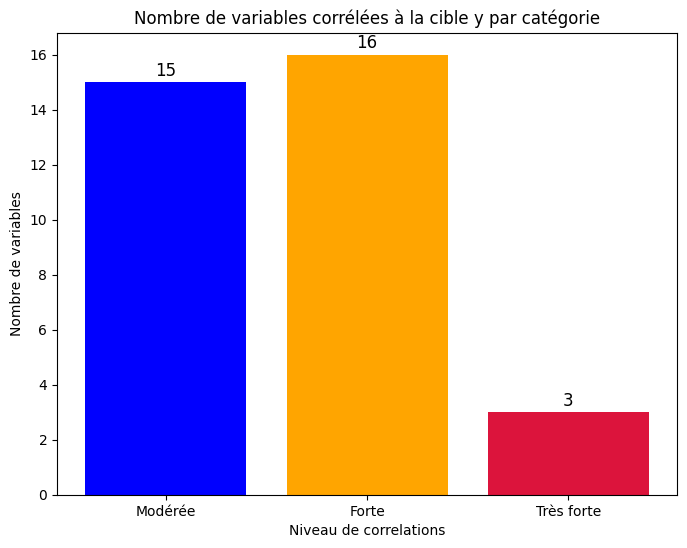

In [24]:

labels = ["Modérée","Forte","Très forte"]
values = [len(moderate_correlations),len(strong_correlations),len(very_strong_correlations)]

plt.figure(figsize=(8,6))
bars = plt.bar(labels, values, color=['blue', 'orange', 'crimson'])

plt.title("Nombre de variables corrélées à la cible y par catégorie")
plt.xlabel("Niveau de correlations")
plt.ylabel("Nombre de variables")

for bar in bars:
  height = bar.get_height()
  plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.1,
        str(height),
        ha='center',
        va='bottom',
        fontsize=12
  )


In [25]:
# Filtrer les colonnes qui commencent par "Déperdition"
deperdition_columns = [col for col in data.columns if col.lower().startswith("déperdition")]

# Compter ces colonnes
deperdition_count = len(deperdition_columns)

deperdition_count

4

In [26]:
pd.DataFrame(data.columns, columns=["Column Names"])

,Column Names
0,Date_réception_DPE
1,Date_établissement_DPE
2,Date_visite_diagnostiqueur
3,Date_fin_validité_DPE
4,Version_DPE
...,...
101,Surface_habitable_desservie_par_installation_ECS
102,Conso_é_finale_générateur_ECS_n°1
103,Conso_é_finale_dépensier_générateur_ECS_n°1
104,Volume_stockage_générateur_ECS_n°1


# REGRESSION LINEAIRE 1

## REGRESSION

### IMPLEMENTATION DU MODELE

In [27]:
# MODELE DE REGRESSION LINEAIRE

X = data.drop(columns=["conso_nrj_m2_par_an"])
y = data["conso_nrj_m2_par_an"]

X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X1_train, y1_train)

y1_pred = model.predict(X1_test)


# EVALUATION
mse_1 = mean_squared_error(y1_test, y1_pred)
r2_1 = r2_score(y1_test, y1_pred)

print(f"Mean Squared Error: {mse_1}")
print(f"R-squared: {r2_1}")


# COEFS
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

Mean Squared Error: 0.017651752971541926
R-squared: 0.9823636634710736


Le modèle montre de très bonne performance, car la régression linéaire semble expliquer 98 % de la variabilité de la consommation d’énergie par m². Mais il y a surement un risque d'overfitting, et de colinearité, nottament comme on a pu le voir avec les variables corrélées plus haut. Le modele peut possiblement "trop apprendre".
il faut vérifier la robustesse du modèle.

### VERIFICATION DES HYPS DU MODELE

https://www.alliage-ad.com/tutoriels-r/comment-verifier-les-hypotheses-de-la-regression-lineaire/

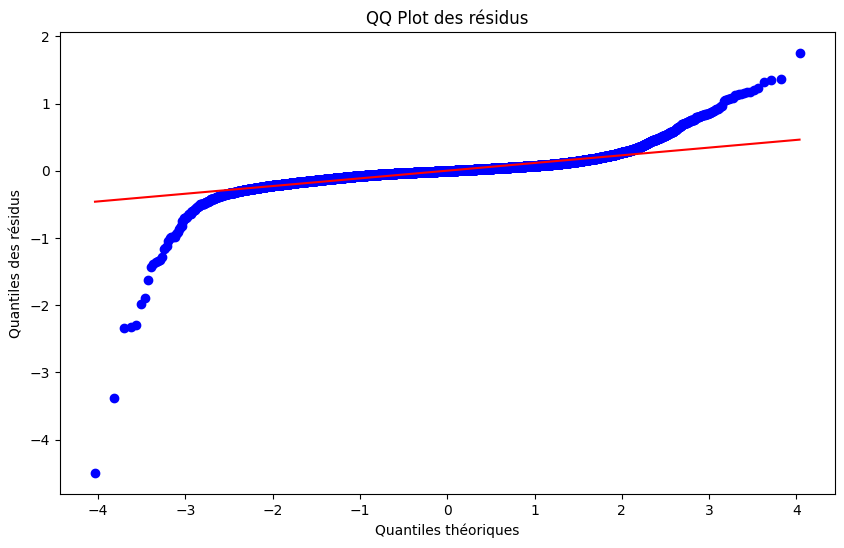

In [28]:
# HYPOTHESE DE NORMALITE DES RESIDUS

# Calculer les résidus
residuals = y1_test - y1_pred

# Tracer le QQ plot des résidus
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot des résidus")
plt.xlabel("Quantiles théoriques")
plt.ylabel("Quantiles des résidus")
plt.show()

--> résidus ne suivent pas exactement une loi normale : présence de kurtosis élevée

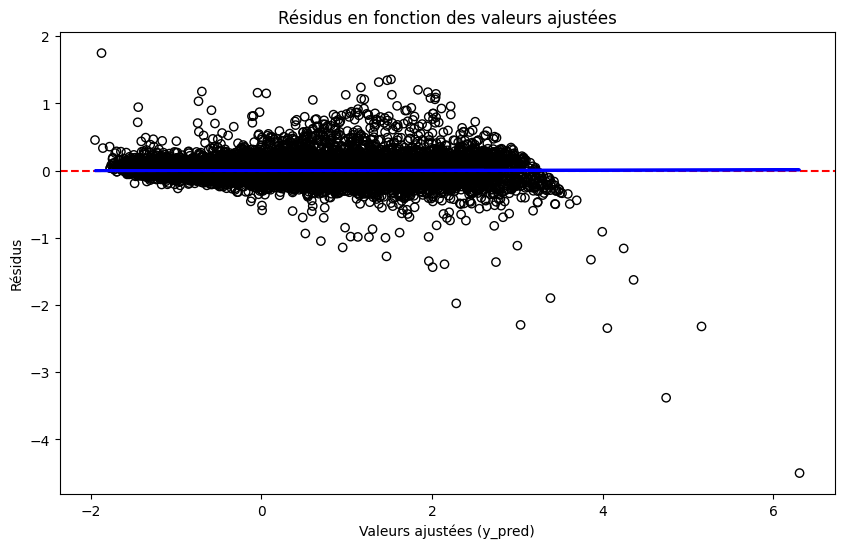

In [29]:
# HYPOTHESE DE LINEARITE DU MODELE

# Tracer les résidus en fonction des valeurs ajustées
plt.figure(figsize=(10, 6))
plt.scatter(y1_pred, residuals, edgecolor='k', facecolor='none')
plt.axhline(y=0, color='r', linestyle='--')

# Ajuster une ligne de tendance aux résidus
z = np.polyfit(y1_pred, residuals, 1)
p = np.poly1d(z)
plt.plot(y1_pred, p(y1_pred), color='blue', linestyle='-', linewidth=2)

plt.title("Résidus en fonction des valeurs ajustées")
plt.xlabel("Valeurs ajustées (y_pred)")
plt.ylabel("Résidus")
plt.show()

--> droite de tendance quasi horizontale --> relation linéaire

## ANALYSE DE COLINEARITE DES VARIABLES

In [30]:
# COLINEARITE DES VARIABLES

X_numeric = X.apply(pd.to_numeric, errors='coerce')

# Remplir les valeurs manquantes avec la moyenne de chaque colonne
X_numeric = X_numeric.fillna(X_numeric.mean())


# Calculer le VIF : Variance Inflation Factor
# VIF = 1 : Aucune corrélation entre cette variable et les autres variables explicatives.
# 1 < VIF < 5 : Corrélation modérée, généralement acceptable.
# VIF ≥ 5 : Corrélation élevée, potentiellement problématique.
# VIF ≥ 10 : Corrélation très élevée, indiquant une multicolinéarité sévère

vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print(vif_data)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                              feature           VIF
0                                  Date_réception_DPE  7.414718e+01
1                              Date_établissement_DPE  7.414914e+01
2                          Date_visite_diagnostiqueur  1.039154e+00
3                               Date_fin_validité_DPE  3.348359e-03
4                                         Version_DPE  0.000000e+00
..                                                ...           ...
100  Surface_habitable_desservie_par_installation_ECS  2.178193e+01
101                 Conso_é_finale_générateur_ECS_n°1           inf
102       Conso_é_finale_dépensier_générateur_ECS_n°1  4.545486e+10
103                Volume_stockage_générateur_ECS_n°1  2.378355e+00
104              Production_électricité_PV_(kWhep/an)  1.084397e+00

[105 rows x 2 columns]


In [31]:
vif_data = vif_data.sort_values(by='VIF', ascending=False)
vif_data.rename(columns={"feature": "Variable"}, inplace=True)
vif_data.head(15)

,Variable,VIF
101,Conso_é_finale_générateur_ECS_n°1,inf
97,Conso_é_finale_installation_ECS,inf
102,Conso_é_finale_dépensier_générateur_ECS_n°1,4.545486e+10
98,Conso_é_finale_dépensier_installation_ECS,4.545463e+10
20,Conso_5_usages_é_finale,3.080352e+07
21,Conso_chauffage_é_finale,2.810379e+07
33,Conso_éclairage_é_primaire,8.085382e+06
23,Conso_éclairage_é_finale,8.085262e+06
29,Conso_5_usages_é_primaire,7.654213e+06
31,Conso_chauffage_é_primaire,6.607160e+06


In [32]:
vif_data['VIF'].describe()

,VIF
count,105.000000
mean,inf
std,NaN
min,0.000000
25%,4.604432
50%,74.147179
75%,3950.402834
max,inf


--> au vu de la mediane (=77), il y a beaucoup de colinearite parmi notre jeu de donnes de variables explicatives

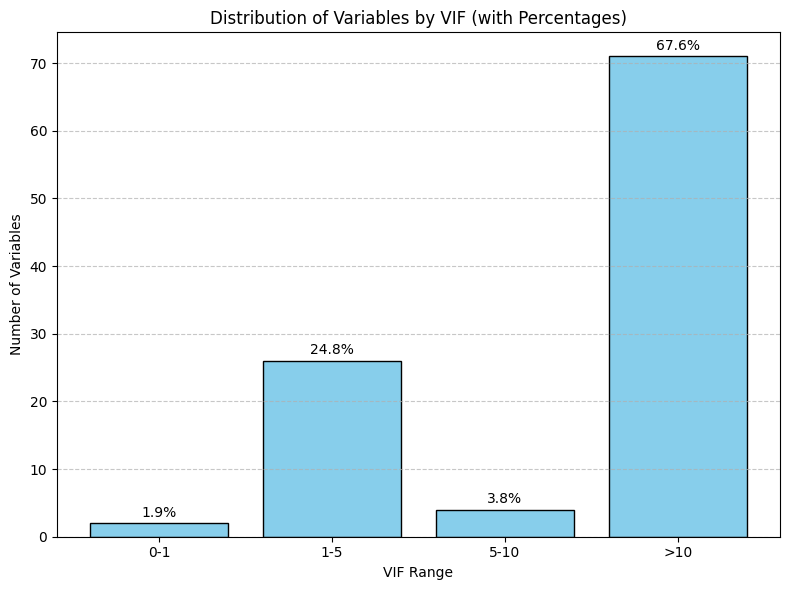

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Définir les bins pour catégoriser les VIF
bins = [0, 1, 5, 10, np.inf]  # Par exemple : 0-1, 1-5, 5-10, >10
labels = ["0-1", "1-5", "5-10", ">10"]

# Ajouter une colonne 'bin' dans le DataFrame vif_data
vif_data["VIF Bin"] = pd.cut(vif_data["VIF"], bins=bins, labels=labels, right=False)

# Compter le nombre de variables dans chaque bin
vif_counts = vif_data["VIF Bin"].value_counts().sort_index()

# Calculer les pourcentages
total_variables = vif_data.shape[0]
vif_percentages = (vif_counts / total_variables) * 100

# Tracer un graphique
plt.figure(figsize=(8, 6))
bars = plt.bar(vif_counts.index, vif_counts, color="skyblue", edgecolor="black")

# Ajouter les étiquettes des pourcentages
for bar, percentage in zip(bars, vif_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{percentage:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Ajouter les titres et axes
plt.xlabel("VIF Range")
plt.ylabel("Number of Variables")
plt.title("Distribution of Variables by VIF (with Percentages)")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


## ANALYSE DES COEFS

### DISTRIBUTION DES COEFS

In [34]:
coefficients['Coefficient'].describe()

,Coefficient
count,105.000000
mean,0.009425
std,13.747730
min,-98.819985
25%,-0.039429
50%,-0.001189
75%,0.014310
max,99.109001


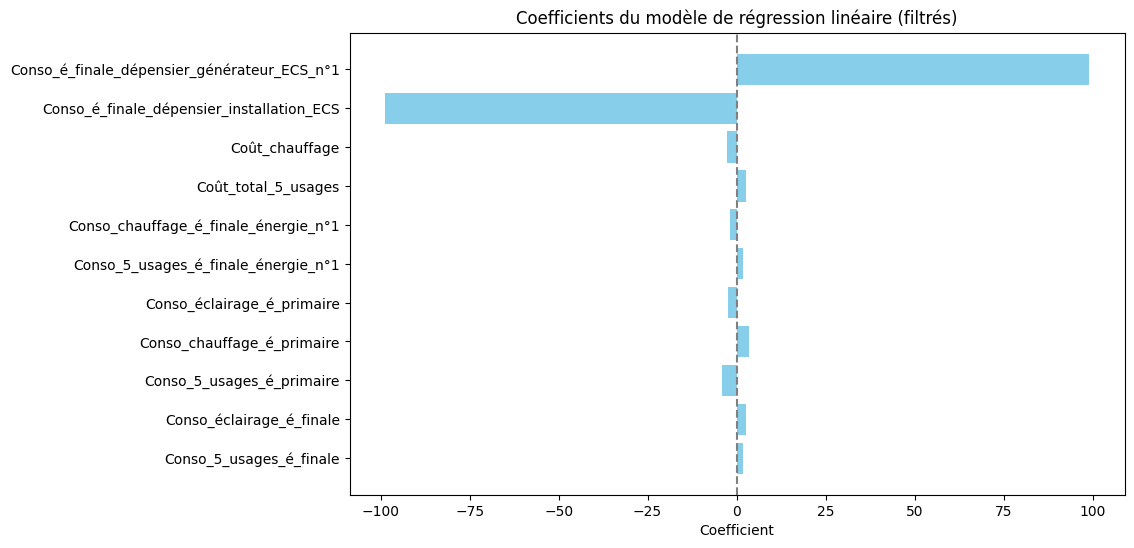

In [35]:
mean_coef = coefficients['Coefficient'].mean()
std_coef = coefficients['Coefficient'].std()

# Filtrer les coefficients qui sont supérieurs ou inférieurs à la moyenne de plus de 0.1 écart type
filtered_coefficients = coefficients[(coefficients['Coefficient'] > mean_coef + 0.1 * std_coef) |
                                     (coefficients['Coefficient'] < mean_coef - 0.1 * std_coef)]

# Tracer les coefficients filtrés
plt.figure(figsize=(10, 6))
plt.barh(filtered_coefficients.index, filtered_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Coefficients du modèle de régression linéaire (filtrés)')
plt.axvline(x=0, color='grey', linestyle='--')
plt.show()

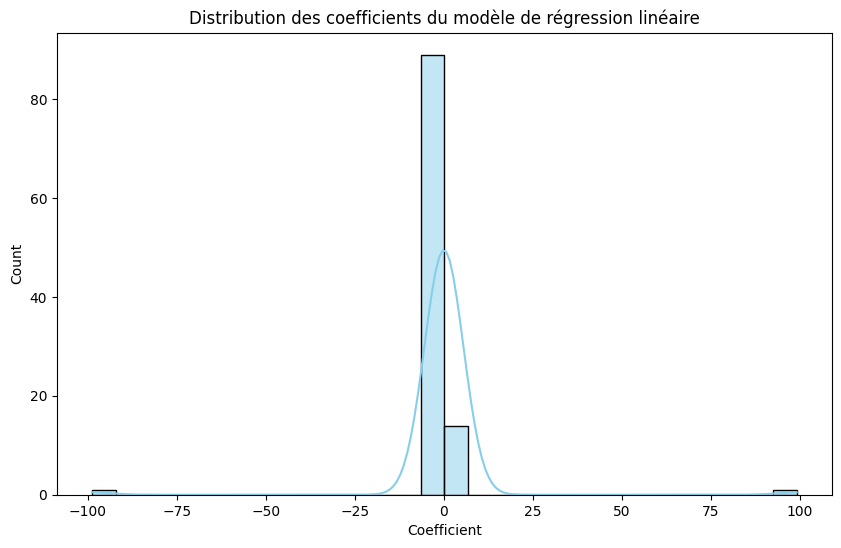

In [36]:
# Tracer la distribution des coefficients
plt.figure(figsize=(10, 6))
sns.histplot(coefficients['Coefficient'], kde=True, bins=30, color='skyblue')
plt.xlabel('Coefficient')
plt.title('Distribution des coefficients du modèle de régression linéaire')
plt.show()

### TOP COEFS

In [37]:
top_N = 10

top_abs = coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index).head(top_N)
print("Top coefficients par valeur absolue :")
top_abs

Top coefficients par valeur absolue :


,Coefficient
Conso_é_finale_dépensier_générateur_ECS_n°1,99.109001
Conso_é_finale_dépensier_installation_ECS,-98.819985
Conso_5_usages_é_primaire,-4.104003
Conso_chauffage_é_primaire,3.402246
Coût_total_5_usages,2.649971
Coût_chauffage,-2.645487
Conso_éclairage_é_finale,2.552870
Conso_éclairage_é_primaire,-2.352610
Conso_chauffage_é_finale_énergie_n°1,-1.926611
Conso_5_usages_é_finale_énergie_n°1,1.832627


In [38]:
top_pos = coefficients[coefficients['Coefficient'] > 0].sort_values(by='Coefficient', ascending=False).head(top_N)
print("\nTop coefficients par valeur positive :")
top_pos


Top coefficients par valeur positive :


,Coefficient
Conso_é_finale_dépensier_générateur_ECS_n°1,99.109001
Conso_chauffage_é_primaire,3.402246
Coût_total_5_usages,2.649971
Conso_éclairage_é_finale,2.552870
Conso_5_usages_é_finale_énergie_n°1,1.832627
Conso_5_usages_é_finale,1.687788
Conso_chauffage_générateur_n°1_installation_n°1,0.636988
Emission_GES_5_usages_par_m²,0.545897
Conso_5_usages_par_m²_é_primaire,0.511296
Conso_chauffage_dépensier_é_finale,0.483744


In [39]:
top_neg = coefficients[coefficients['Coefficient'] < 0].sort_values(by='Coefficient', ascending=True).head(top_N)
print("\nTop coefficients par valeur négative :")
top_neg


Top coefficients par valeur négative :


,Coefficient
Conso_é_finale_dépensier_installation_ECS,-98.819985
Conso_5_usages_é_primaire,-4.104003
Coût_chauffage,-2.645487
Conso_éclairage_é_primaire,-2.352610
Conso_chauffage_é_finale_énergie_n°1,-1.926611
Conso_chauffage_é_finale,-1.082705
Conso_chauffage_dépensier_générateur_n°1_installation_n°1,-0.563195
Emission_GES_5_usages,-0.555043
Date_établissement_DPE,-0.183755
Date_fin_validité_DPE,-0.183755


## ANALYSE DE CORRELATION

In [40]:
# TRANSPOSITION DE LA MATRICE DE CORREL EN TABLEAU

correlation_matrix = X.corr()

# stocker les couples de variables et leurs coefficients de corrélation
correlation_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        correlation = correlation_matrix.iloc[i, j]
        correlation_pairs.append((var1, var2, correlation))

correlation_df = pd.DataFrame(correlation_pairs, columns=['Variable 1', 'Variable 2', 'Correlation'])

correlation_df

,Variable 1,Variable 2,Correlation
0,Date_réception_DPE,Date_établissement_DPE,0.991715
1,Date_réception_DPE,Date_visite_diagnostiqueur,0.139095
2,Date_réception_DPE,Date_fin_validité_DPE,0.991715
3,Date_réception_DPE,Version_DPE,NaN
4,Date_réception_DPE,Etiquette_GES,-0.008288
...,...,...,...
5455,Conso_é_finale_générateur_ECS_n°1,Volume_stockage_générateur_ECS_n°1,0.091398
5456,Conso_é_finale_générateur_ECS_n°1,Production_électricité_PV_(kWhep/an),-0.047127
5457,Conso_é_finale_dépensier_générateur_ECS_n°1,Volume_stockage_générateur_ECS_n°1,0.051665
5458,Conso_é_finale_dépensier_générateur_ECS_n°1,Production_électricité_PV_(kWhep/an),-0.049743


In [41]:
correlation_df['Correlation'].describe()

,Correlation
count,5356.000000
mean,0.198258
std,0.283478
min,-0.815890
25%,-0.003070
50%,0.099589
75%,0.368913
max,1.000000


In [42]:
# AFFICHE LES COUPLES DE VARIABLE AYANT UNE CORREL >= SEUIL

seuil = 0.75
top_N = 10

high_correl = correlation_df[correlation_df['Correlation']>=seuil]
print(f"Nombre de coefficients de correl >= {seuil} : {high_correl.shape[0]}/{correlation_df.shape[0]} (= {high_correl.shape[0]/correlation_df.shape[0]*100:.2f}%)")
top_correl = high_correl.sort_values(by='Correlation', ascending=False).head(top_N)

top_correl

Nombre de coefficients de correl >= 0.75 : 385/5460 (= 7.05%)


,Variable 1,Variable 2,Correlation
5435,Conso_é_finale_installation_ECS,Conso_é_finale_générateur_ECS_n°1,1.000000
105,Date_établissement_DPE,Date_fin_validité_DPE,1.000000
5442,Conso_é_finale_dépensier_installation_ECS,Conso_é_finale_dépensier_générateur_ECS_n°1,1.000000
2148,Conso_éclairage_é_finale,Conso_éclairage_é_primaire,1.000000
2388,Conso_refroidissement_é_finale,Conso_refroidissement_é_primaire,0.999993
2543,Conso_auxiliaires_é_finale,Conso_auxiliaires_é_primaire,0.999983
5415,Conso_chauffage_générateur_n°1_installation_n°1,Conso_chauffage_dépensier_générateur_n°1_insta...,0.999226
5382,Conso_chauffage_installation_chauffage_n°1,Conso_chauffage_dépensier_installation_chauffa...,0.999094
1974,Conso_chauffage_é_finale,Conso_chauffage_dépensier_é_finale,0.999089
1007,Surface_habitable_logement,Conso_éclairage_é_finale,0.998563


In [43]:
# DETERMINER VARIABLES COUPABLES DE CORREL ELEVEES

seuil = 0.75

# Filtrer les variables corrélées au-dessus du seuil
high_correl = correlation_df[correlation_df['Correlation'] >= seuil]

# Compter pour chaque variable le nombre de fois que le coef de correl depasse le seuil
high_correl_counts = pd.concat([
    high_correl['Variable 1'],
    high_correl['Variable 2']
]).value_counts()

max_possible_count = len(high_correl_counts) - 1
print(f"Nombre maximal de count possible selon le seuil : {max_possible_count}")

# Afficher les variables les plus corrélées
high_correl_counts.head(10)

Nombre maximal de count possible selon le seuil : 76


,count
Coût_chauffage,25
Coût_total_5_usages,25
Conso_5_usages_é_finale,25
Conso_chauffage_é_finale,25
Conso_chauffage_dépensier_é_finale,25
Conso_chauffage_installation_chauffage_n°1,24
Conso_chauffage_dépensier_générateur_n°1_installation_n°1,24
Conso_chauffage_générateur_n°1_installation_n°1,24
Coût_chauffage_dépensier,24
Conso_chauffage_é_finale_énergie_n°1,24


In [44]:
# CREATION D'UN GRAND TABLEAU D'ANALYSE DES VARIABLES
# 'Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation'


# Calculer la matrice de corrélation des variables explicatives
correlation_matrix = X.corr()

# Dictionnaires permettant de stocker les valeurs pour calculer 'Mean Correlation'
correlation_sums = {col: 0 for col in correlation_matrix.columns}
correlation_counts = {col: 0 for col in correlation_matrix.columns}

# Parcourir la matrice de corrélation pour extraire les couples de variables et leurs coefficients de corrélation
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        correlation = correlation_matrix.iloc[i, j]

        # Vérifier si la corrélation n'est pas NaN
        if not pd.isna(correlation):
            # Ajouter la corrélation aux sommes et incrémenter les compteurs
            correlation_sums[var1] += abs(correlation)
            correlation_sums[var2] += abs(correlation)
            correlation_counts[var1] += 1
            correlation_counts[var2] += 1

# Calculer la corrélation moyenne pour chaque variable
correlation_means = {var: correlation_sums[var] / correlation_counts[var] for var in correlation_sums if correlation_counts[var] > 0}
correlation_means_df = pd.DataFrame(list(correlation_means.items()), columns=['Variable', 'Mean Correlation'])

# Ajouter les top3 des variables corrélées à la variable var
top_correlations = {var: [] for var in correlation_matrix.columns}
for var in correlation_matrix.columns:
    sorted_correlations = correlation_matrix[var].abs().sort_values(ascending=False)
    top_3 = sorted_correlations.index[1:4]      # Exclure la corrélation avec elle-même : la premiere est la plus elevee, elle vaut 1, c est la correl de la variable avec elle meme
    top_correlations[var] = [f"{v} ({correlation_matrix.loc[var, v]:.2f})" for v in top_3]

correlation_means_df['Top 1 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][0])
correlation_means_df['Top 2 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][1])
correlation_means_df['Top 3 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][2])


# Coefs de la regression lineaire
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
correlation_means_df = correlation_means_df.merge(coefficients, left_on='Variable', right_index=True)

# Correl avec y
correlations_df = correlations_with_y.reset_index()
correlations_df.columns = ["Variable", "correl_y"]
correlation_means_df = correlation_means_df.merge(correlations_df, on='Variable')

# Coef VIF
correlation_means_df = correlation_means_df.merge(vif_data, on='Variable')


# Traitement du tableau final
cols = ['Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation']
correlation_means_df = correlation_means_df[cols]
correlation_means_df = correlation_means_df.sort_values(by='correl_y', ascending=False)

# Exportation
correlation_means_df.to_excel('correlation_coef_vif_reg1.xlsx', index=False)


correlation_means_df.head(15)

,Variable,Coefficient,correl_y,VIF,Mean Correlation,Top 1 Correlation,Top 2 Correlation,Top 3 Correlation
4,Etiquette_GES,0.011789,0.827910,2.142389e+01,0.284680,Emission_GES_5_usages_par_m² (0.95),Emission_GES_5_usages (0.76),Emission_GES_5_usages_énergie_n°1 (0.73)
39,Emission_GES_5_usages_par_m²,0.545897,0.823775,1.884292e+01,0.282430,Etiquette_GES (0.95),Emission_GES_5_usages (0.81),Emission_GES_5_usages_énergie_n°1 (0.77)
5,Etiquette_DPE,0.003913,0.807683,1.416796e+01,0.266534,Conso_5_usages_par_m²_é_primaire (0.92),Ubat_W/m²_K (0.62),Etiquette_GES (0.60)
29,Conso_5_usages_par_m²_é_primaire,0.511296,0.760790,1.325832e+01,0.236223,Etiquette_DPE (0.92),Ubat_W/m²_K (0.61),Conso_chauffage_é_primaire (0.60)
91,Conso_chauffage_installation_chauffage_n°1,-0.065547,0.711165,1.332440e+04,0.412392,Conso_chauffage_dépensier_installation_chauffa...,Conso_chauffage_é_finale (0.98),Conso_chauffage_dépensier_é_finale (0.98)
94,Conso_chauffage_générateur_n°1_installation_n°1,0.636988,0.706705,1.331749e+04,0.405681,Conso_chauffage_dépensier_générateur_n°1_insta...,Conso_chauffage_é_finale_énergie_n°1 (0.99),Conso_5_usages_é_finale_énergie_n°1 (0.98)
92,Conso_chauffage_dépensier_installation_chauffa...,0.058827,0.706642,1.317124e+04,0.412597,Conso_chauffage_installation_chauffage_n°1 (1.00),Conso_chauffage_dépensier_é_finale (0.98),Conso_chauffage_é_finale (0.98)
95,Conso_chauffage_dépensier_générateur_n°1_insta...,-0.563195,0.702036,1.306161e+04,0.405685,Conso_chauffage_générateur_n°1_installation_n°...,Conso_chauffage_é_finale_énergie_n°1 (0.98),Conso_5_usages_é_finale_énergie_n°1 (0.98)
20,Conso_chauffage_é_finale,-1.082705,0.700350,2.810379e+07,0.416887,Conso_chauffage_dépensier_é_finale (1.00),Conso_5_usages_é_finale (1.00),Conso_chauffage_installation_chauffage_n°1 (0.98)
49,Conso_chauffage_é_finale_énergie_n°1,-1.926611,0.698375,9.699798e+03,0.410180,Conso_5_usages_é_finale_énergie_n°1 (1.00),Conso_chauffage_générateur_n°1_installation_n°...,Conso_chauffage_dépensier_générateur_n°1_insta...


In [45]:
correlation_means_df["Mean Correlation"].describe()

,Mean Correlation
count,104.000000
mean,0.230440
std,0.128469
min,0.003866
25%,0.114395
50%,0.239305
75%,0.346140
max,0.421662


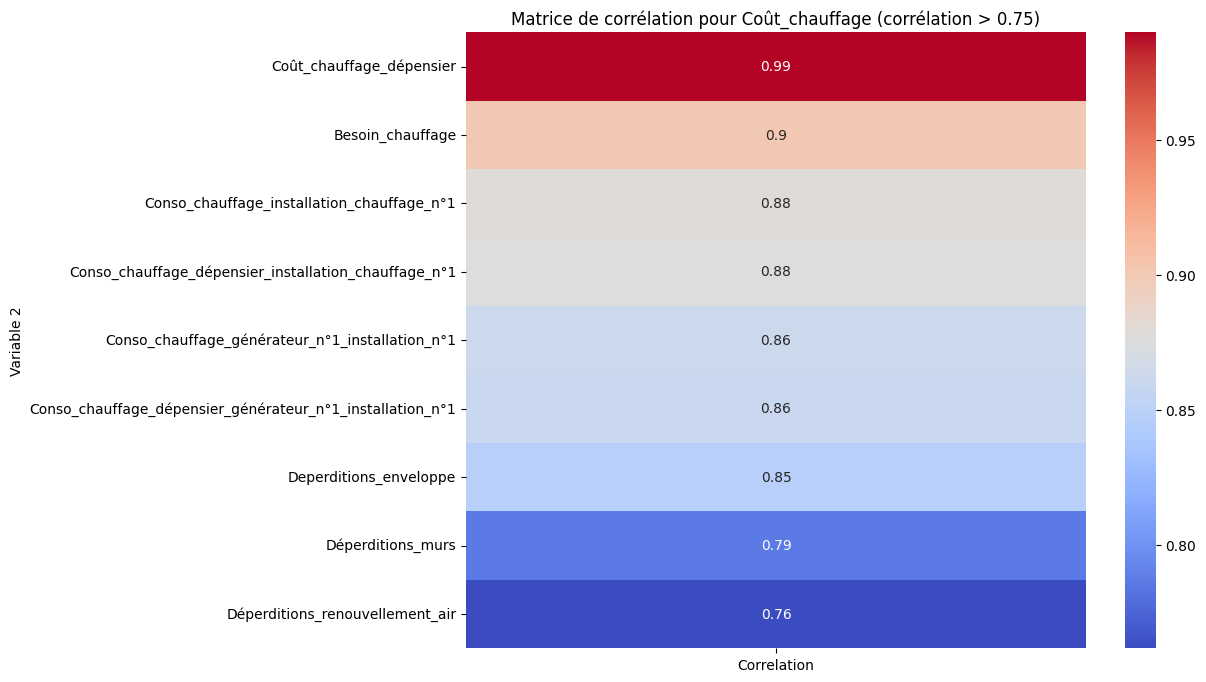

In [46]:
# SCRIPT POUR EXTRAIRE LES CORRELATIONS POUR UNE VARIABLE AVEC LES AUTRES SELON UN SEUIL DE CORREL

# A choisir
variable_name = 'Coût_chauffage'    # variable à analyser
seuil = 0.75                        # seuil de correl

correlation_with_variable = correlation_df.loc[correlation_df['Variable 1'] == variable_name, ['Variable 2', 'Correlation']]


# Filtrer les corrélations supérieures au seuil
correlation_with_variable = correlation_with_variable[correlation_with_variable['Correlation'] > seuil]
correlation_with_variable = correlation_with_variable.sort_values(by='Correlation', ascending=False)
correlation_with_variable = correlation_with_variable.set_index('Variable 2')

# Afficher la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_with_variable, annot=True, cmap='coolwarm', cbar=True)
plt.title(f"Matrice de corrélation pour {variable_name} (corrélation > {seuil})")
plt.show()

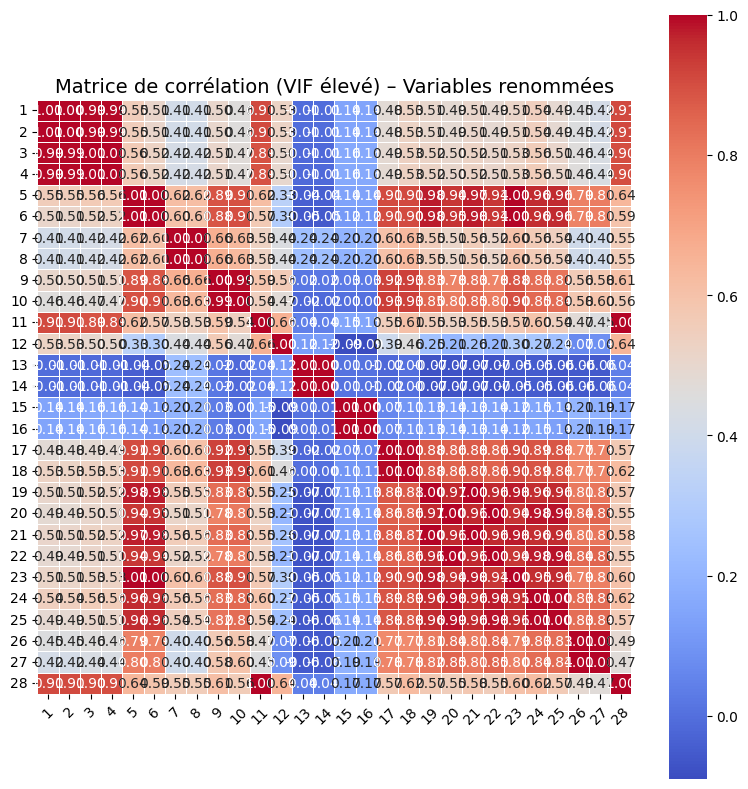


=== Correspondance : label numérique -> nom de variable original ===
1: Conso_é_finale_générateur_ECS_n°1
2: Conso_é_finale_installation_ECS
3: Conso_é_finale_dépensier_générateur_ECS_n°1
4: Conso_é_finale_dépensier_installation_ECS
5: Conso_5_usages_é_finale
6: Conso_chauffage_é_finale
7: Conso_éclairage_é_primaire
8: Conso_éclairage_é_finale
9: Conso_5_usages_é_primaire
10: Conso_chauffage_é_primaire
11: Conso_ECS_é_finale
12: Conso_ECS_é_primaire
13: Conso_refroidissement_é_finale
14: Conso_refroidissement_é_primaire
15: Conso_auxiliaires_é_primaire
16: Conso_auxiliaires_é_finale
17: Coût_chauffage
18: Coût_total_5_usages
19: Conso_chauffage_installation_chauffage_n°1
20: Conso_chauffage_générateur_n°1_installation_n°1
21: Conso_chauffage_dépensier_installation_chauffage_n°1
22: Conso_chauffage_dépensier_générateur_n°1_installation_n°1
23: Conso_chauffage_dépensier_é_finale
24: Conso_5_usages_é_finale_énergie_n°1
25: Conso_chauffage_é_finale_énergie_n°1
26: Emission_GES_5_usages_én

In [47]:

import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Définition du seuil de VIF
threshold_vif = 3000
high_vif_variables = vif_data[
    vif_data["VIF"] >= threshold_vif
]["Variable"].tolist()


#matrice
if len(high_vif_variables) > 1:

    sub_corr_matrix = X_numeric[high_vif_variables].corr()

    #{nom_original: "1", "2", ...}
    short_names_map = {
        var: str(idx + 1) for idx, var in enumerate(high_vif_variables)
    }

    # Renommer l'index et les colonnes de la sous-matrice de corrélation
    sub_corr_matrix_renamed = sub_corr_matrix.rename(
        index=short_names_map,
        columns=short_names_map
    )

    plt.figure(figsize=(8, 8))
    sns.heatmap(
        sub_corr_matrix_renamed,
        annot=True,
        cmap="coolwarm",
        linewidths=0.5,
        fmt=".2f",
        square=True
    )
    plt.title("Matrice de corrélation (VIF élevé) – Variables renommées", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\n=== Correspondance : label numérique -> nom de variable original ===")
    for original_var, short_name in short_names_map.items():
        print(f"{short_name}: {original_var}")

else:
    print("\nAucune variable avec un VIF supérieur ou égal au seuil spécifié.")



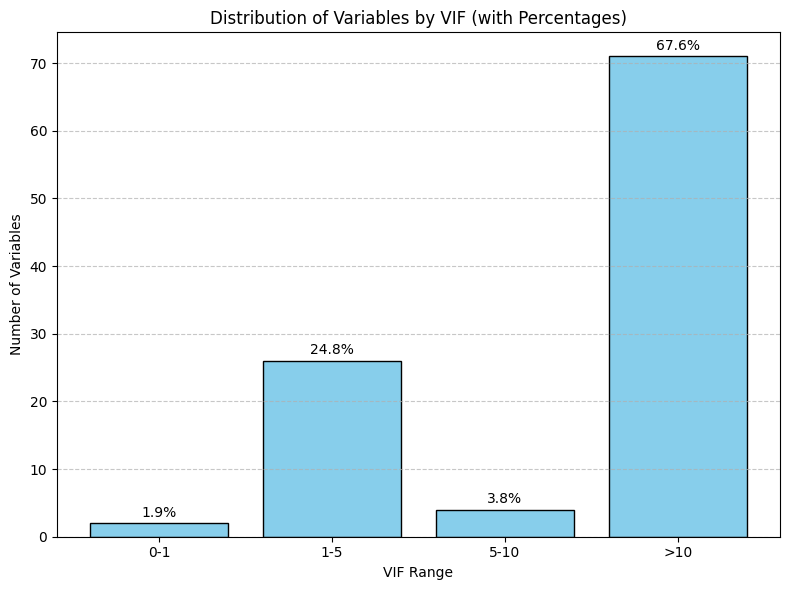

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Définir les bins pour catégoriser les VIF
bins = [0, 1, 5, 10, np.inf]  # Par exemple : 0-1, 1-5, 5-10, >10
labels = ["0-1", "1-5", "5-10", ">10"]

# Ajouter une colonne 'bin' dans le DataFrame vif_data
vif_data["VIF Bin"] = pd.cut(vif_data["VIF"], bins=bins, labels=labels, right=False)

# Compter le nombre de variables dans chaque bin
vif_counts = vif_data["VIF Bin"].value_counts().sort_index()

# Calculer les pourcentages
total_variables = vif_data.shape[0]
vif_percentages = (vif_counts / total_variables) * 100

# Tracer un graphique
plt.figure(figsize=(8, 6))
bars = plt.bar(vif_counts.index, vif_counts, color="skyblue", edgecolor="black")

# Ajouter les étiquettes des pourcentages
for bar, percentage in zip(bars, vif_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{percentage:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Ajouter les titres et axes
plt.xlabel("VIF Range")
plt.ylabel("Number of Variables")
plt.title("Distribution of Variables by VIF (with Percentages)")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## REGRESSION AVEC REGULARISATION

In [49]:
# REGULARISATION LASSO : pour éliminer des variables

# Utiliser LassoCV pour trouver les hyperparamètres optimaux
lasso = LassoCV(cv=5, random_state=42).fit(X1_train, y1_train)
y_pred = lasso.predict(X1_test)

# Eval
mse = mean_squared_error(y1_test, y_pred)
r2 = r2_score(y1_test, y1_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Meilleur alpha trouvé par LassoCV: {lasso.alpha_}")

# Coefs
lasso_coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso.coef_})

Mean Squared Error: 0.749410578128091
R-squared: 0.9823636634710736
Meilleur alpha trouvé par LassoCV: 2.0302315427670266


--> score ok mais sans plus

In [50]:
# COEFS ABS LES PLUS GRANDS
top_N = 10
top_abs = lasso_coefficients.reindex(lasso_coefficients['Coefficient'].abs().sort_values(ascending=False).index).head(top_N)
print("Top coefficients par valeur absolue :")
top_abs

Top coefficients par valeur absolue :


,Variable,Coefficient
7,Période_construction,0.016143
19,N°_région_(BAN),-0.002195
18,Code_postal_(brut),0.000004
14,Code_postal_(BAN),-0.000002
68,Présence_brasseur_air_(0/1),-0.000000
78,Déperditions_ponts_thermiques,0.000000
77,Deperditions_planchers_hauts,0.000000
76,Deperditions_planchers_bas,0.000000
75,Déperditions_murs,0.000000
74,Deperditions_enveloppe,0.000000


--> coefs très petits

In [51]:
# REGULARISATION ELASTICNET : pour supprimer moins de variables que Lasso et réduire les coefs afin de gérer la multicolinearite
# On espere garder un peu plus de variables

# Utiliser ElasticNetCV pour trouver les hyperparamètres optimaux
elastic_net = ElasticNetCV(cv=5, random_state=42).fit(X1_train, y1_train)
y_pred = elastic_net.predict(X1_test)

# Évaluation
mse = mean_squared_error(y1_test, y1_pred)
r2 = r2_score(y1_test, y1_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Meilleur alpha trouvé par ElasticNetCV: {elastic_net.alpha_}")
print(f"Meilleur l1_ratio trouvé par ElasticNetCV: {elastic_net.l1_ratio_}")

# Coefs
elastic_net_coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': elastic_net.coef_})

Mean Squared Error: 0.017651752971541926
R-squared: 0.9823636634710736
Meilleur alpha trouvé par ElasticNetCV: 4.060463085534053
Meilleur l1_ratio trouvé par ElasticNetCV: 0.5


--> score legerement inferieur à Lasso

In [52]:
# COEFS ABS LES PLUS GRANDS
top_N = 10
top_abs = elastic_net_coefficients.reindex(elastic_net_coefficients['Coefficient'].abs().sort_values(ascending=False).index).head(top_N)
print("Top coefficients par valeur absolue :")
top_abs

Top coefficients par valeur absolue :


,Variable,Coefficient
7,Période_construction,0.016091
19,N°_région_(BAN),-0.002191
18,Code_postal_(brut),0.000004
14,Code_postal_(BAN),-0.000002
68,Présence_brasseur_air_(0/1),-0.000000
78,Déperditions_ponts_thermiques,0.000000
77,Deperditions_planchers_hauts,0.000000
76,Deperditions_planchers_bas,0.000000
75,Déperditions_murs,0.000000
74,Deperditions_enveloppe,0.000000


--> pas de grande difference avec les coefs du modele Lasso, et meme nombre de variables séléctionnées

In [53]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score


best_alpha_lasso = lasso.alpha_
best_alpha_elastic = elastic_net.alpha_
best_l1_ratio_elastic = elastic_net.l1_ratio_

#modele
models = {
    "OLS": LinearRegression(),
    "Lasso": Lasso(alpha=best_alpha_lasso, random_state=42),
    "ElasticNet": ElasticNet(alpha=best_alpha_elastic, l1_ratio=best_l1_ratio_elastic, random_state=42)
}


kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_results = {}
r2_results = {}
coefficients = {name: [] for name in models.keys()}

#  validation croisée
for train_idx, test_idx in kf.split(X):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    for name, model in models.items():

        model.fit(X_train_cv, y_train_cv)
        coefficients[name].append(model.coef_)

        y_pred = model.predict(X_test_cv)
        mse_results.setdefault(name, []).append(mean_squared_error(y_test_cv, y_pred))
        r2_results.setdefault(name, []).append(r2_score(y_test_cv, y_pred))


summary = []
for name in models.keys():
    mse_mean = np.mean(mse_results[name])
    mse_std = np.std(mse_results[name])
    r2_mean = np.mean(r2_results[name])
    r2_std = np.std(r2_results[name])
    summary.append({
        "Model": name,
        "MSE Mean": mse_mean,
        "MSE Std": mse_std,
        "R² Mean": r2_mean,
        "R² Std": r2_std
    })

summary_df = pd.DataFrame(summary)

coefficients_std = {}
for name, coefs in coefficients.items():
    coefs_array = np.array(coefs)
    coefficients_std[name] = coefs_array.std(axis=0)


stability_df = pd.DataFrame({
    "Feature": X.columns,
    "Std_OLS": coefficients_std["OLS"],
    "Std_Lasso": coefficients_std["Lasso"],
    "Std_ElasticNet": coefficients_std["ElasticNet"]
}).sort_values(by="Std_OLS", ascending=False)


print("=== Résumé des performances (MSE et R²) ===")
print(summary_df)

print("\n=== Stabilité des coefficients ===")
print(stability_df)


mean_std = {
    name: np.mean(std) for name, std in coefficients_std.items()
}
print("\n=== Moyenne de l'écart-type des coefficients ===")
for name, mean_std_value in mean_std.items():
    print(f"{name} : {mean_std_value:.4f}")




=== Résumé des performances (MSE et R²) ===
        Model  MSE Mean   MSE Std   R² Mean    R² Std
0         OLS  0.018003  0.001684  0.982004  0.001592
1       Lasso  0.748716  0.004077  0.251261  0.000501
2  ElasticNet  0.748944  0.004083  0.251034  0.000500

=== Stabilité des coefficients ===
                                         Feature       Std_OLS     Std_Lasso  \
102  Conso_é_finale_dépensier_générateur_ECS_n°1  4.275098e+01  0.000000e+00   
98     Conso_é_finale_dépensier_installation_ECS  4.274485e+01  0.000000e+00   
20                       Conso_5_usages_é_finale  3.811728e+00  0.000000e+00   
21                      Conso_chauffage_é_finale  3.693636e+00  0.000000e+00   
29                     Conso_5_usages_é_primaire  1.893582e+00  0.000000e+00   
..                                           ...           ...           ...   
19                               N°_région_(BAN)  1.878814e-05  2.170611e-05   
7                           Période_construction  1.861796e-05  

### Résumé des Résultats

 **Performances des Modèles :**
   - **OLS** offre les meilleures performances avec un MSE très faible (0.018) et un \(R^2\) élevé (0.982), expliquant 98,2% de la variance de la cible. Cependant, ses coefficients sont instables (écart-type moyen : 0.9532), en partie à cause de la multicolinéarité entre les variables explicatives.
   - **Lasso** et **ElasticNet**, bien que stables (écart-type moyen des coefficients = 0.0), affichent des performances nettement inférieures (\(R^2\) ≈ 0.251, MSE ≈ 0.749), indiquant une sous-régularisation (underfitting).
   Cependant, une régularisation trop forte semble avoir pénalisé leurs performances globales.
  
  il serait interessant de revoir les parametres



In [54]:
"""a tester : from sklearn.linear_model import LassoCV, ElasticNetCV

# Recherche plus fine des hyperparamètres
lasso_cv = LassoCV(alphas=np.logspace(-4, 0, 100), cv=10).fit(X, y)
elastic_cv = ElasticNetCV(alphas=np.logspace(-4, 0, 100), l1_ratio=np.linspace(0.1, 0.9, 10), cv=10).fit(X, y)
"""

'a tester : from sklearn.linear_model import LassoCV, ElasticNetCV\n\n# Recherche plus fine des hyperparamètres\nlasso_cv = LassoCV(alphas=np.logspace(-4, 0, 100), cv=10).fit(X, y)\nelastic_cv = ElasticNetCV(alphas=np.logspace(-4, 0, 100), l1_ratio=np.linspace(0.1, 0.9, 10), cv=10).fit(X, y)\n'

## SUPPRESSION DES VARIABLES

### SUPPRESION DES VARIABLES NON PERTINENTES

Dans un premier temps nous enlevons toutes les variables qui ne concerne pas notre besoin metier : les données sur la consommation, les coûts, ou les émissions qui ne sont pas directement des leviers d’amélioration de l’isolation.

In [55]:
columns_to_drop = [
# Dates et identifiants
    "Date_réception_DPE", "Date_établissement_DPE", "Date_visite_diagnostiqueur",
    "Date_fin_validité_DPE", "Version_DPE",

    # Informations générales
    "Etiquette_GES", "Etiquette_DPE", "Période_construction",
    "Hauteur_sous-plafond", "Nombre_niveau_logement", "Surface_habitable_logement",
    "Classe_inertie_bâtiment", "Classe_altitude", "Zone_climatique_",
    "Code_postal_(BAN)", "Score_BAN", "Coordonnée_cartographique_X_(BAN)",
    "Coordonnée_cartographique_Y_(BAN)", "Code_postal_(brut)", "N°_région_(BAN)",

    # Consommation énergétique
    "Conso_5_usages_é_finale", "Conso_chauffage_é_finale", "Conso_chauffage_dépensier_é_finale",
    "Conso_éclairage_é_finale", "Conso_ECS_é_finale", "Conso_ECS_dépensier_é_finale",
    "Conso_refroidissement_é_finale", "Conso_refroidissement_dépensier_é_finale",
    "Conso_auxiliaires_é_finale", "Conso_5_usages_é_primaire", "Conso_5_usages_par_m²_é_primaire",
    "Conso_chauffage_é_primaire", "Conso_chauffage_dépensier_é_primaire", "Conso_éclairage_é_primaire",
    "Conso_ECS_é_primaire", "Conso_ECS_dépensier_é_primaire", "Conso_refroidissement_é_primaire",
    "Conso_refroidissement_dépensier_é_primaire", "Conso_auxiliaires_é_primaire",

    # Émissions de gaz à effet de serre (GES)
    "Emission_GES_5_usages", "Emission_GES_5_usages_par_m²", "Emission_GES_chauffage",
    "Emission_GES_chauffage_dépensier", "Emission_GES_éclairage", "Emission_GES_ECS",
    "Emission_GES_ECS_dépensier", "Emission_GES_refroidissement",
    "Emission_GES_refroidissement_dépensier", "Emission_GES_auxiliaires",

    # Coûts
    "Coût_total_5_usages_énergie_n°1", "Coût_chauffage_énergie_n°1",
    "Coût_ECS_énergie_n°1", "Coût_total_5_usages", "Coût_chauffage",
    "Coût_chauffage_dépensier", "Coût_éclairage", "Coût_ECS",
    "Coût_ECS_dépensier", "Coût_refroidissement", "Coût_refroidissement_dépensier",
    "Coût_auxiliaires",

    # Autres variables non pertinentes pour l’isolation
    "Production_électricité_PV_(kWhep/an)", "Besoin_refroidissement_dépensier",
    "Conso_chauffage_installation_chauffage_n°1",
    "Conso_chauffage_dépensier_installation_chauffage_n°1",
    "Surface_chauffée_installation_chauffage_n°1",
    "Conso_chauffage_générateur_n°1_installation_n°1",
    "Conso_chauffage_dépensier_générateur_n°1_installation_n°1",
    "Conso_é_finale_installation_ECS", "Conso_é_finale_dépensier_installation_ECS",
    "Nombre_logements_desservis_par_installation_ECS",
    "Surface_habitable_desservie_par_installation_ECS",
    "Conso_é_finale_générateur_ECS_n°1",
    "Conso_é_finale_dépensier_générateur_ECS_n°1",
    "Volume_stockage_générateur_ECS_n°1"
]

data_cleaned = data.drop(columns=columns_to_drop)
data_cleaned.head(10)

,conso_nrj_m2_par_an,Conso_5_usages_é_finale_énergie_n°1,Conso_chauffage_é_finale_énergie_n°1,Conso_ECS_é_finale_énergie_n°1,Emission_GES_5_usages_énergie_n°1,Emission_GES_chauffage_énergie_n°1,Emission_GES_ECS_énergie_n°1,Logement_traversant_(0/1),Présence_brasseur_air_(0/1),Indicateur_confort_été,...,Qualité_isolation_enveloppe,Qualité_isolation_menuiseries,Qualité_isolation_murs,Qualité_isolation_plancher_bas,Ubat_W/m²_K,Apports_internes_saison_chauffe_,Apports_internes_saison_froid,Apports_solaires_saison_chauffe,Apports_solaires_saison_froid,Besoin_chauffage
0,0.685970,0.300263,0.221683,1.130888,0.440206,0.342374,1.442292,1,0,-0.643741,...,1.052854,-0.624197,0.910740,0.861331,0.203458,-0.490504,-0.149487,-0.374362,-0.120456,0.127881
1,-0.963054,-0.294827,-0.395122,0.845745,-0.514004,-0.514802,-0.320722,1,0,-2.139149,...,-0.757167,-0.624197,-0.854819,-0.065890,-0.663287,-0.489370,-0.149487,-0.374145,-0.120456,-0.412381
2,-0.215804,-0.104828,-0.145895,0.372723,-0.459682,-0.444818,-0.437934,1,0,-2.139149,...,1.052854,0.451096,0.910740,-0.065890,0.107153,1.914207,2.891435,1.537913,1.688816,0.569414
3,-1.159091,0.179803,0.191653,-0.982610,-0.379870,-0.350016,-0.773197,1,0,0.851667,...,1.052854,0.451096,0.910740,0.861331,1.816568,-0.487584,-0.143373,-0.373610,-0.118341,2.724268
4,-0.236561,0.052903,0.032302,0.267248,-0.416025,-0.394775,-0.463981,1,0,-0.643741,...,1.052854,1.526388,-0.854819,-0.065890,0.131229,-0.490380,-0.149487,-0.373719,-0.120456,0.161126
5,-1.205218,-0.864605,-0.846463,-0.046829,-0.467847,-0.519583,0.424596,1,0,0.851667,...,-1.662177,-0.624197,-1.737599,-1.920332,-1.000355,-0.490669,-0.149487,-0.374324,-0.120456,-1.090529
6,-1.205218,-0.888609,-0.870795,-0.045558,-0.486587,-0.539210,0.425712,1,0,0.851667,...,-1.662177,-1.699489,-1.737599,-1.920332,-1.409651,-0.490485,-0.149487,-0.374559,-0.120456,-1.102809
7,-1.136028,-0.937785,-0.906487,-0.199029,-0.524911,-0.568022,0.293244,1,0,0.851667,...,-1.662177,-1.699489,-1.737599,-1.920332,-1.313346,-0.490870,-0.149487,-0.374459,-0.120456,-1.137761
8,-1.262876,-0.795189,-0.874476,0.249067,-0.648740,-0.649424,-0.468446,1,0,-0.643741,...,-1.662177,0.451096,-0.854819,-0.993111,-1.024431,-0.490720,-0.144120,-0.375286,-0.118701,-0.745223
9,0.732096,1.378958,1.557974,-1.613991,-0.487400,-0.425505,-0.929479,1,0,0.851667,...,1.052854,-0.624197,0.910740,0.861331,1.912873,-0.488851,-0.146474,-0.373176,-0.117737,3.491558


--> On estime qu'en tant que prestataire de travaux, nous ne pouvons pas agir sur ces variables pour améliorer l'efficacité énergétique du logement. Ou bien que ces variables n'apportent pas d'information sur l'efficacité énergétique.

### SUPPRESSION DES VARIABLES TRES COLINEAIRES

Selection manuelle des variables. On elimine des variables qui sont très colineaires avec d'autres (sur la base du VIF et du Mean Correlation) et qui sont redondantes à d'autres (correl proche de 1 avec d'autres variables).

--> Les variables sélectionnées présentent une forte colinéarité avec les autres variables et ont des coefs de corrélation proches de 1 avec d'autres variables.  
--> On décide de supprimer ces variables

# REGRESSIONS LINEAIRES SEQUENTIELLES

## REGRESSION 2

On refait une regression seulement avec les colonnes gardées

In [56]:
# MODELE DE REGRESSION LINEAIRE

X = data_cleaned.drop(columns=["conso_nrj_m2_par_an"])
y = data_cleaned["conso_nrj_m2_par_an"]

X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.2, random_state=42)

model2 = LinearRegression()
model2.fit(X2_train, y2_train)

y2_pred = model2.predict(X2_test)


# EVALUATION
mse_2 = mean_squared_error(y2_test, y2_pred)
r2_2 = r2_score(y2_test, y2_pred)

print(f"Mean Squared Error: {mse_2}")
print(f"R-squared: {r2_2}")


# COEFS
coefficients2 = pd.DataFrame(model2.coef_, X.columns, columns=['Coefficient'])

Mean Squared Error: 0.22748901413913386
R-squared: 0.7727096670534817


--> meme score que regression 1  
--> supprimer des variables n'a pas enlevé d'information au modèle

In [57]:
top_N = 10

top_abs = coefficients2.reindex(coefficients2['Coefficient'].abs().sort_values(ascending=False).index).head(top_N)
print("Top coefficients par valeur absolue :")
top_abs

Top coefficients par valeur absolue :


,Coefficient
Conso_chauffage_é_finale_énergie_n°1,3.781558
Conso_5_usages_é_finale_énergie_n°1,-3.215215
Besoin_chauffage,0.500984
Déperditions_murs,-0.366659
Déperditions_renouvellement_air,-0.304016
Ubat_W/m²_K,0.296489
Conso_ECS_é_finale_énergie_n°1,0.262627
Deperditions_baies_vitrées,-0.235643
Deperditions_enveloppe,0.182463
Deperditions_planchers_hauts,-0.152156


In [58]:
# COLINEARITE DES VARIABLES

X_numeric = X.apply(pd.to_numeric, errors='coerce')

# Remplir les valeurs manquantes avec la moyenne de chaque colonne
X_numeric = X_numeric.fillna(X_numeric.mean())


# Calculer le VIF : Variance Inflation Factor
# VIF = 1 : Aucune corrélation entre cette variable et les autres variables explicatives.
# 1 < VIF < 5 : Corrélation modérée, généralement acceptable.
# VIF ≥ 5 : Corrélation élevée, potentiellement problématique.
# VIF ≥ 10 : Corrélation très élevée, indiquant une multicolinéarité sévère

vif_data = pd.DataFrame()
vif_data["Variable"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print(vif_data)

                                Variable          VIF
0    Conso_5_usages_é_finale_énergie_n°1  2536.147393
1   Conso_chauffage_é_finale_énergie_n°1  2404.049366
2         Conso_ECS_é_finale_énergie_n°1    31.447026
3      Emission_GES_5_usages_énergie_n°1  4033.022746
4     Emission_GES_chauffage_énergie_n°1  3702.811120
5           Emission_GES_ECS_énergie_n°1    31.096227
6              Logement_traversant_(0/1)     5.230810
7            Présence_brasseur_air_(0/1)     1.626278
8                 Indicateur_confort_été     2.287076
9                Isolation_toiture_(0/1)     6.372352
10   Protection_solaire_exterieure_(0/1)     3.977487
11                  Inertie_lourde_(0/1)     1.485774
12            Deperditions_baies_vitrées    19.059025
13                Deperditions_enveloppe   650.480200
14                     Déperditions_murs   133.134178
15            Deperditions_planchers_bas     8.925567
16          Deperditions_planchers_hauts    24.320352
17         Déperditions_pont

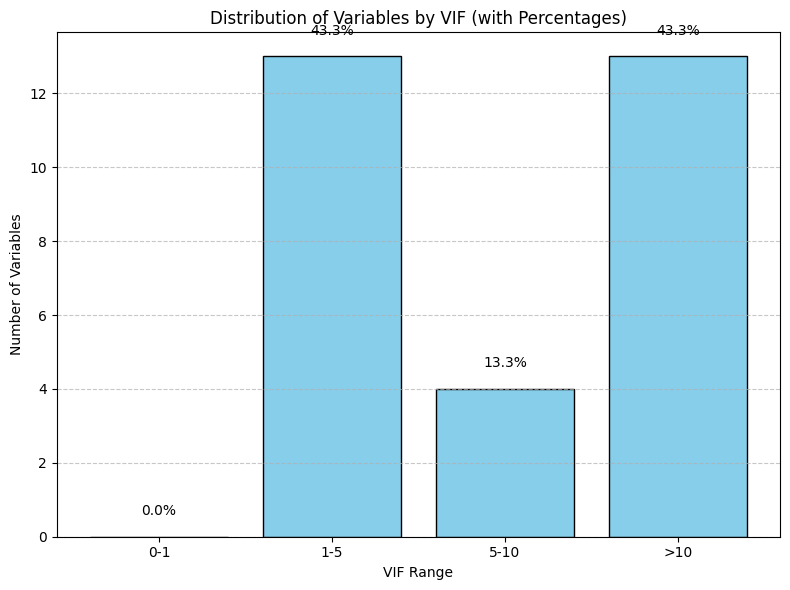

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Définir les bins pour catégoriser les VIF
bins = [0, 1, 5, 10, np.inf]  # Par exemple : 0-1, 1-5, 5-10, >10
labels = ["0-1", "1-5", "5-10", ">10"]

# Ajouter une colonne 'bin' dans le DataFrame vif_data
vif_data["VIF Bin"] = pd.cut(vif_data["VIF"], bins=bins, labels=labels, right=False)

# Compter le nombre de variables dans chaque bin
vif_counts = vif_data["VIF Bin"].value_counts().sort_index()

# Calculer les pourcentages
total_variables = vif_data.shape[0]
vif_percentages = (vif_counts / total_variables) * 100

# Tracer un graphique
plt.figure(figsize=(8, 6))
bars = plt.bar(vif_counts.index, vif_counts, color="skyblue", edgecolor="black")

# Ajouter les étiquettes des pourcentages
for bar, percentage in zip(bars, vif_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{percentage:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Ajouter les titres et axes
plt.xlabel("VIF Range")
plt.ylabel("Number of Variables")
plt.title("Distribution of Variables by VIF (with Percentages)")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [60]:
# CREATION D'UN GRAND TABLEAU D'ANALYSE DES VARIABLES
# 'Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation'


# Calculer la matrice de corrélation des variables explicatives
correlation_matrix = X.corr()

# Dictionnaires permettant de stocker les valeurs pour calculer 'Mean Correlation'
correlation_sums = {col: 0 for col in correlation_matrix.columns}
correlation_counts = {col: 0 for col in correlation_matrix.columns}

# Parcourir la matrice de corrélation pour extraire les couples de variables et leurs coefficients de corrélation
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        correlation = correlation_matrix.iloc[i, j]

        # Vérifier si la corrélation n'est pas NaN
        if not pd.isna(correlation):
            # Ajouter la corrélation aux sommes et incrémenter les compteurs
            correlation_sums[var1] += abs(correlation)
            correlation_sums[var2] += abs(correlation)
            correlation_counts[var1] += 1
            correlation_counts[var2] += 1

# Calculer la corrélation moyenne pour chaque variable
correlation_means = {var: correlation_sums[var] / correlation_counts[var] for var in correlation_sums if correlation_counts[var] > 0}
correlation_means_df = pd.DataFrame(list(correlation_means.items()), columns=['Variable', 'Mean Correlation'])

# Ajouter les top3 des variables corrélées à la variable var
top_correlations = {var: [] for var in correlation_matrix.columns}
for var in correlation_matrix.columns:
    sorted_correlations = correlation_matrix[var].abs().sort_values(ascending=False)
    top_3 = sorted_correlations.index[1:4]      # Exclure la corrélation avec elle-même : la premiere est la plus elevee, elle vaut 1, c est la correl de la variable avec elle meme
    top_correlations[var] = [f"{v} ({correlation_matrix.loc[var, v]:.2f})" for v in top_3]

correlation_means_df['Top 1 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][0])
correlation_means_df['Top 2 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][1])
correlation_means_df['Top 3 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][2])


# Coefs de la regression lineaire

coefficients2 = pd.DataFrame(model2.coef_, X.columns, columns=['Coefficient'])
correlation_means_df = correlation_means_df.merge(coefficients2, left_on='Variable', right_index=True)

# Correl avec y
correlations_df = correlations_with_y.reset_index()
correlations_df.columns = ["Variable", "correl_y"]
correlation_means_df = correlation_means_df.merge(correlations_df, on='Variable')

# Coef VIF
correlation_means_df = correlation_means_df.merge(vif_data, on='Variable')


# Traitement du tableau final
cols = ['Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation']
correlation_means_df = correlation_means_df[cols]
correlation_means_df = correlation_means_df.sort_values(by='correl_y', ascending=False)

# Exportation
correlation_means_df.to_excel('correlation_coef_vif_reg2.xlsx', index=False)


correlation_means_df

,Variable,Coefficient,correl_y,VIF,Mean Correlation,Top 1 Correlation,Top 2 Correlation,Top 3 Correlation
1,Conso_chauffage_é_finale_énergie_n°1,3.781558,0.698375,2404.049366,0.418713,Conso_5_usages_é_finale_énergie_n°1 (1.00),Besoin_chauffage (0.87),Emission_GES_chauffage_énergie_n°1 (0.84)
24,Ubat_W/m²_K,0.296489,0.694644,6.339194,0.349419,Qualité_isolation_enveloppe (0.81),Déperditions_murs (0.70),Qualité_isolation_murs (0.68)
0,Conso_5_usages_é_finale_énergie_n°1,-3.215215,0.681736,2536.147393,0.424672,Conso_chauffage_é_finale_énergie_n°1 (1.00),Besoin_chauffage (0.88),Emission_GES_chauffage_énergie_n°1 (0.84)
20,Qualité_isolation_enveloppe,0.030258,0.614777,4.613972,0.318126,Ubat_W/m²_K (0.81),Qualité_isolation_murs (0.75),Déperditions_murs (0.58)
4,Emission_GES_chauffage_énergie_n°1,-0.089645,0.603011,3702.811120,0.361963,Emission_GES_5_usages_énergie_n°1 (1.00),Conso_chauffage_é_finale_énergie_n°1 (0.84),Conso_5_usages_é_finale_énergie_n°1 (0.84)
3,Emission_GES_5_usages_énergie_n°1,0.059690,0.597901,4033.022746,0.361994,Emission_GES_chauffage_énergie_n°1 (1.00),Conso_chauffage_é_finale_énergie_n°1 (0.83),Conso_5_usages_é_finale_énergie_n°1 (0.83)
22,Qualité_isolation_murs,0.118600,0.585688,3.008395,0.276830,Qualité_isolation_enveloppe (0.75),Ubat_W/m²_K (0.68),Déperditions_murs (0.57)
29,Besoin_chauffage,0.500984,0.571153,18.302997,0.443201,Deperditions_enveloppe (0.95),Déperditions_murs (0.89),Conso_5_usages_é_finale_énergie_n°1 (0.88)
14,Déperditions_murs,-0.366659,0.521557,133.134178,0.401867,Deperditions_enveloppe (0.90),Besoin_chauffage (0.89),Conso_5_usages_é_finale_énergie_n°1 (0.77)
13,Deperditions_enveloppe,0.182463,0.434817,650.480200,0.448246,Besoin_chauffage (0.95),Déperditions_murs (0.90),Déperditions_renouvellement_air (0.90)


In [61]:
# IDENTIFICATION DES VARIABLES TROP CORRELEES

import re

data_corel = pd.read_excel('correlation_coef_vif_reg2.xlsx', sheet_name='Sheet1')

# Fonction pour extraire nom de variable et correl
def extract_correlations(correlation_column):
    correlations = []
    for entry in correlation_column.dropna():
        match = re.findall(r"(.+?) \(([\d.]+)\)", entry)
        if match:
            correlations.extend([(var.strip(), float(coeff)) for var, coeff in match])
    return correlations

# Extraire les correls
correlation_columns = ['Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation']
all_correlations = []

for column in correlation_columns:
    all_correlations.extend(extract_correlations(data_corel[column]))

# Organiser en groupe cohérent de vraiables ayant des corels > 0.95
strong_correlations = [(data_corel['Variable'][i], pair[0], pair[1])
                       for i, column in enumerate(correlation_columns)
                       for pair in extract_correlations(data_corel[column]) if pair[1] > 0.95]
strong_corr_df = pd.DataFrame(strong_correlations, columns=['Variable', 'Correlated With', 'Correlation'])
strong_corr_df.sort_values(by='Correlation', ascending=False, inplace=True)


# Exportation
strong_corr_df.to_excel('strong_corr_df_reg2.xlsx', index=False)

strong_corr_df.head(5)


,Variable,Correlated With,Correlation
0,Conso_chauffage_é_finale_énergie_n°1,Conso_5_usages_é_finale_énergie_n°1,1.0
1,Conso_chauffage_é_finale_énergie_n°1,Conso_chauffage_é_finale_énergie_n°1,1.0
2,Conso_chauffage_é_finale_énergie_n°1,Emission_GES_5_usages_énergie_n°1,1.0
3,Conso_chauffage_é_finale_énergie_n°1,Emission_GES_chauffage_énergie_n°1,1.0


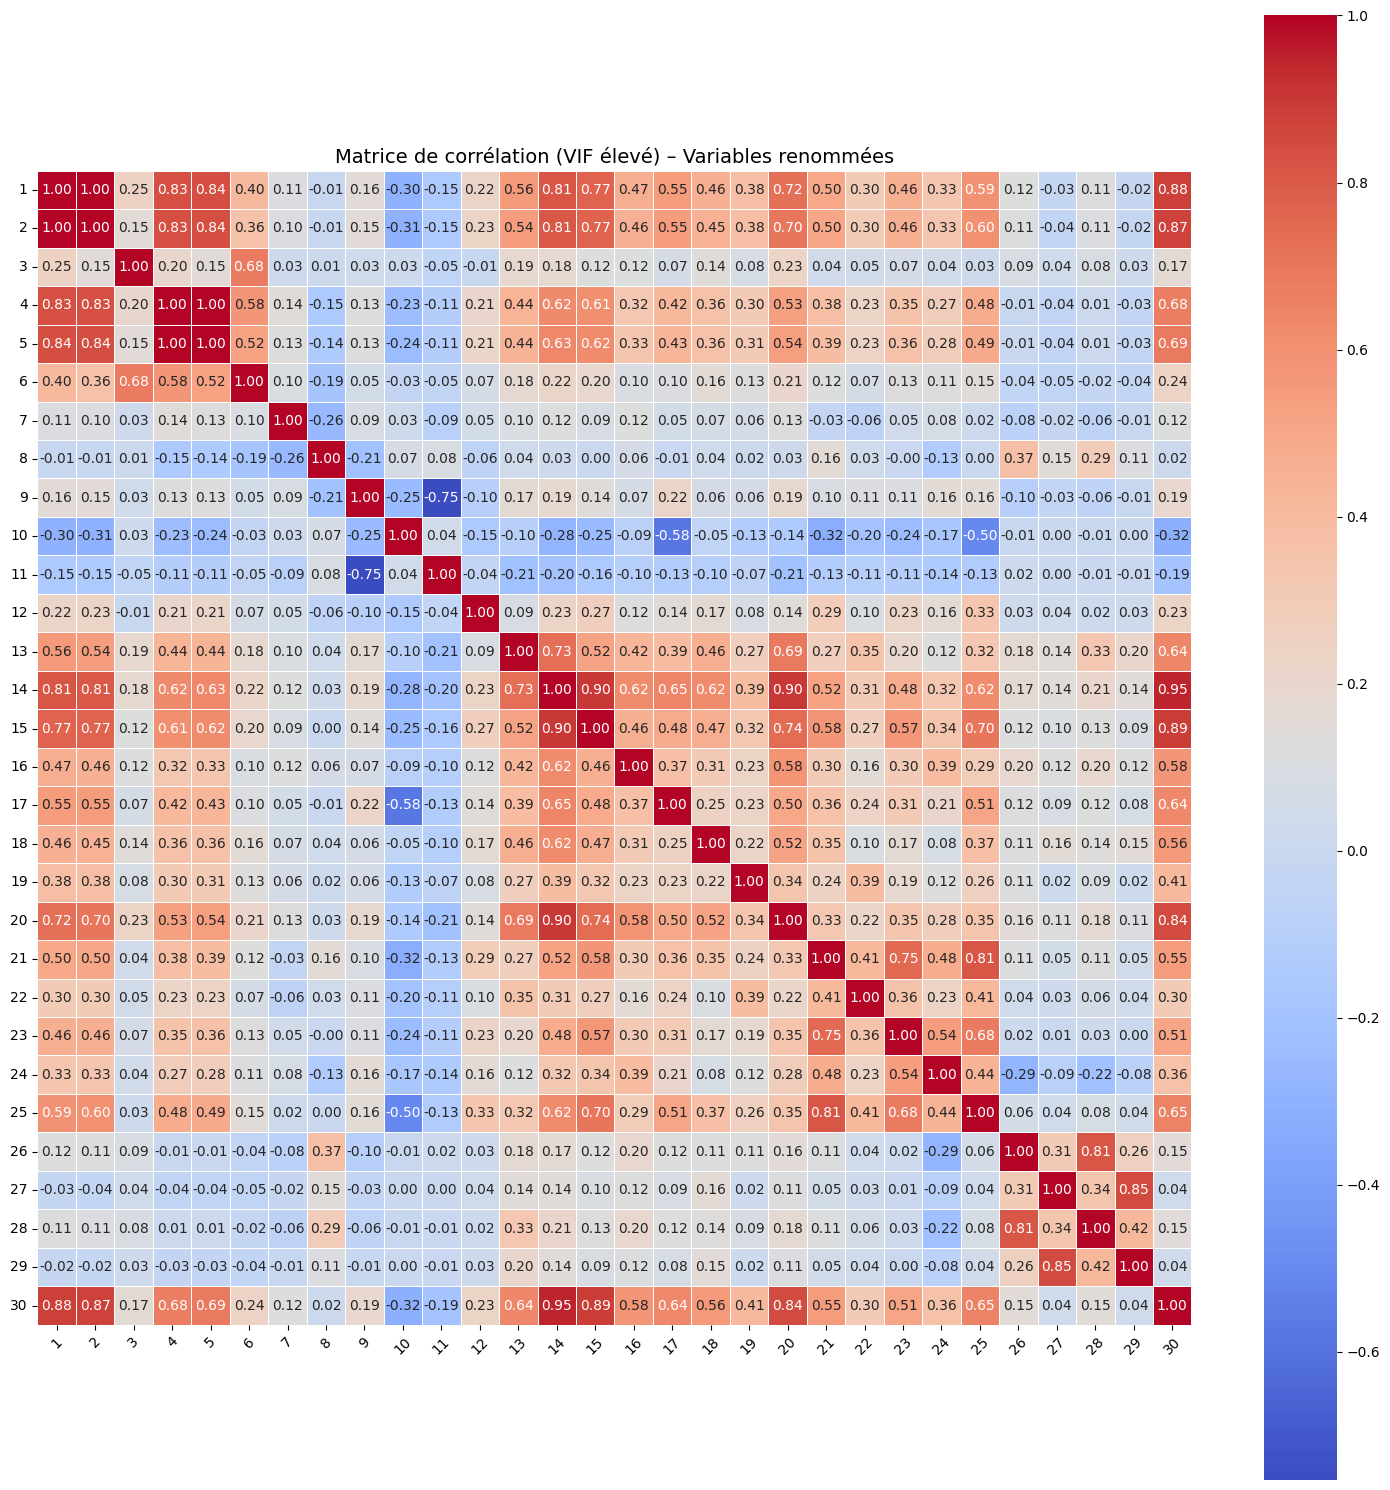


=== Correspondance : label numérique -> nom de variable original ===
1: Conso_5_usages_é_finale_énergie_n°1
2: Conso_chauffage_é_finale_énergie_n°1
3: Conso_ECS_é_finale_énergie_n°1
4: Emission_GES_5_usages_énergie_n°1
5: Emission_GES_chauffage_énergie_n°1
6: Emission_GES_ECS_énergie_n°1
7: Logement_traversant_(0/1)
8: Présence_brasseur_air_(0/1)
9: Indicateur_confort_été
10: Isolation_toiture_(0/1)
11: Protection_solaire_exterieure_(0/1)
12: Inertie_lourde_(0/1)
13: Deperditions_baies_vitrées
14: Deperditions_enveloppe
15: Déperditions_murs
16: Deperditions_planchers_bas
17: Deperditions_planchers_hauts
18: Déperditions_ponts_thermiques
19: Déperditions_portes
20: Déperditions_renouvellement_air
21: Qualité_isolation_enveloppe
22: Qualité_isolation_menuiseries
23: Qualité_isolation_murs
24: Qualité_isolation_plancher_bas
25: Ubat_W/m²_K
26: Apports_internes_saison_chauffe_
27: Apports_internes_saison_froid
28: Apports_solaires_saison_chauffe
29: Apports_solaires_saison_froid
30: Beso

In [62]:

import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Définition du seuil de VIF
threshold_vif = 1
high_vif_variables = vif_data[
    vif_data["VIF"] >= threshold_vif
]["Variable"].tolist()


#matrice
if len(high_vif_variables) > 1:

    sub_corr_matrix = X_numeric[high_vif_variables].corr()

    #{nom_original: "1", "2", ...}
    short_names_map = {
        var: str(idx + 1) for idx, var in enumerate(high_vif_variables)
    }

    # Renommer l'index et les colonnes de la sous-matrice de corrélation
    sub_corr_matrix_renamed = sub_corr_matrix.rename(
        index=short_names_map,
        columns=short_names_map
    )

    plt.figure(figsize=(15, 15))
    sns.heatmap(
        sub_corr_matrix_renamed,
        annot=True,
        cmap="coolwarm",
        linewidths=0.5,
        fmt=".2f",
        square=True
    )
    plt.title("Matrice de corrélation (VIF élevé) – Variables renommées", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\n=== Correspondance : label numérique -> nom de variable original ===")
    for original_var, short_name in short_names_map.items():
        print(f"{short_name}: {original_var}")

else:
    print("\nAucune variable avec un VIF supérieur ou égal au seuil spécifié.")



### SUPPRESSION DES VARIABLES TRES COLINEAIRES

Pareil qu'en regression 1. On elimine des variables qui sont très colineaires avec d'autres (sur la base du VIF et du Mean Correlation) et qui sont redondantes à d'autres (correl proche de 1 avec d'autres variables).

In [63]:
variables_colinear = [
    "Emission_GES_5_usages_énergie_n°1",
    "Conso_chauffage_é_finale_énergie_n°1",
    "Déperditions_renouvellement_air"
]

retrieved_rows = correlation_means_df.loc[correlation_means_df['Variable'].isin(variables_colinear)]
retrieved_rows

,Variable,Coefficient,correl_y,VIF,Mean Correlation,Top 1 Correlation,Top 2 Correlation,Top 3 Correlation
1,Conso_chauffage_é_finale_énergie_n°1,3.781558,0.698375,2404.049366,0.418713,Conso_5_usages_é_finale_énergie_n°1 (1.00),Besoin_chauffage (0.87),Emission_GES_chauffage_énergie_n°1 (0.84)
3,Emission_GES_5_usages_énergie_n°1,0.059690,0.597901,4033.022746,0.361994,Emission_GES_chauffage_énergie_n°1 (1.00),Conso_chauffage_é_finale_énergie_n°1 (0.83),Conso_5_usages_é_finale_énergie_n°1 (0.83)
19,Déperditions_renouvellement_air,-0.304016,0.258945,42.665015,0.377461,Deperditions_enveloppe (0.90),Besoin_chauffage (0.84),Déperditions_murs (0.74)


--> Les variables sélectionnées présentent une forte colinéarité avec les autres variables et ont des coefs de corrélation proches de 1 avec d'autres variables.  
--> On décide de supprimer ces variables

In [64]:
columns_to_drop = [
    "Emission_GES_5_usages_énergie_n°1",
    "Conso_chauffage_é_finale_énergie_n°1",
    "Déperditions_renouvellement_air"
]

data_cleaned3 = data_cleaned.drop(columns=columns_to_drop)
data_cleaned3.head(15)

,conso_nrj_m2_par_an,Conso_5_usages_é_finale_énergie_n°1,Conso_ECS_é_finale_énergie_n°1,Emission_GES_chauffage_énergie_n°1,Emission_GES_ECS_énergie_n°1,Logement_traversant_(0/1),Présence_brasseur_air_(0/1),Indicateur_confort_été,Isolation_toiture_(0/1),Protection_solaire_exterieure_(0/1),...,Qualité_isolation_enveloppe,Qualité_isolation_menuiseries,Qualité_isolation_murs,Qualité_isolation_plancher_bas,Ubat_W/m²_K,Apports_internes_saison_chauffe_,Apports_internes_saison_froid,Apports_solaires_saison_chauffe,Apports_solaires_saison_froid,Besoin_chauffage
0,0.685970,0.300263,1.130888,0.342374,1.442292,1,0,-0.643741,1.0,1,...,1.052854,-0.624197,0.910740,0.861331,0.203458,-0.490504,-0.149487,-0.374362,-0.120456,0.127881
1,-0.963054,-0.294827,0.845745,-0.514802,-0.320722,1,0,-2.139149,1.0,1,...,-0.757167,-0.624197,-0.854819,-0.065890,-0.663287,-0.489370,-0.149487,-0.374145,-0.120456,-0.412381
2,-0.215804,-0.104828,0.372723,-0.444818,-0.437934,1,0,-2.139149,1.0,1,...,1.052854,0.451096,0.910740,-0.065890,0.107153,1.914207,2.891435,1.537913,1.688816,0.569414
3,-1.159091,0.179803,-0.982610,-0.350016,-0.773197,1,0,0.851667,1.0,0,...,1.052854,0.451096,0.910740,0.861331,1.816568,-0.487584,-0.143373,-0.373610,-0.118341,2.724268
4,-0.236561,0.052903,0.267248,-0.394775,-0.463981,1,0,-0.643741,1.0,1,...,1.052854,1.526388,-0.854819,-0.065890,0.131229,-0.490380,-0.149487,-0.373719,-0.120456,0.161126
5,-1.205218,-0.864605,-0.046829,-0.519583,0.424596,1,0,0.851667,1.0,0,...,-1.662177,-0.624197,-1.737599,-1.920332,-1.000355,-0.490669,-0.149487,-0.374324,-0.120456,-1.090529
6,-1.205218,-0.888609,-0.045558,-0.539210,0.425712,1,0,0.851667,1.0,0,...,-1.662177,-1.699489,-1.737599,-1.920332,-1.409651,-0.490485,-0.149487,-0.374559,-0.120456,-1.102809
7,-1.136028,-0.937785,-0.199029,-0.568022,0.293244,1,0,0.851667,1.0,0,...,-1.662177,-1.699489,-1.737599,-1.920332,-1.313346,-0.490870,-0.149487,-0.374459,-0.120456,-1.137761
8,-1.262876,-0.795189,0.249067,-0.649424,-0.468446,1,0,-0.643741,1.0,1,...,-1.662177,0.451096,-0.854819,-0.993111,-1.024431,-0.490720,-0.144120,-0.375286,-0.118701,-0.745223
9,0.732096,1.378958,-1.613991,-0.425505,-0.929479,1,0,0.851667,0.0,0,...,1.052854,-0.624197,0.910740,0.861331,1.912873,-0.488851,-0.146474,-0.373176,-0.117737,3.491558


## REGRESSION 3

meme process que regression 2

In [65]:
# MODELE DE REGRESSION LINEAIRE

X = data_cleaned3.drop(columns=["conso_nrj_m2_par_an"])
y = data_cleaned3["conso_nrj_m2_par_an"]

X3_train, X3_test, y3_train, y3_test = train_test_split(X, y, test_size=0.2, random_state=42)

model3 = LinearRegression()
model3.fit(X3_train, y3_train)

y3_pred = model3.predict(X3_test)


# EVALUATION
mse_3 = mean_squared_error(y3_test, y3_pred)
r2_3 = r2_score(y3_test, y3_pred)

print(f"Mean Squared Error: {mse_3}")
print(f"R-squared: {r2_3}")


# COEFS
coefficients3 = pd.DataFrame(model3.coef_, X.columns, columns=['Coefficient'])

Mean Squared Error: 0.23515803020197384
R-squared: 0.7650473488492759


--> meme coef R2, on n'a pas perdu d'info

In [66]:
top_N = 10

top_abs = coefficients3.reindex(coefficients3['Coefficient'].abs().sort_values(ascending=False).index).head(top_N)
print("Top coefficients par valeur absolue :")
top_abs

Top coefficients par valeur absolue :


,Coefficient
Deperditions_enveloppe,-0.940088
Conso_5_usages_é_finale_énergie_n°1,0.667334
Besoin_chauffage,0.453765
Ubat_W/m²_K,0.323972
Présence_brasseur_air_(0/1),0.168310
Conso_ECS_é_finale_énergie_n°1,-0.160240
Emission_GES_ECS_énergie_n°1,0.158023
Qualité_isolation_murs,0.112395
Déperditions_murs,0.100887
Deperditions_baies_vitrées,-0.085410


In [67]:
# COLINEARITE DES VARIABLES

X_numeric = X.apply(pd.to_numeric, errors='coerce')

# Remplir les valeurs manquantes avec la moyenne de chaque colonne
X_numeric = X_numeric.fillna(X_numeric.mean())


# Calculer le VIF : Variance Inflation Factor
# VIF = 1 : Aucune corrélation entre cette variable et les autres variables explicatives.
# 1 < VIF < 5 : Corrélation modérée, généralement acceptable.
# VIF ≥ 5 : Corrélation élevée, potentiellement problématique.
# VIF ≥ 10 : Corrélation très élevée, indiquant une multicolinéarité sévère

vif_data = pd.DataFrame()
vif_data["Variable"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print(vif_data)

                               Variable        VIF
0   Conso_5_usages_é_finale_énergie_n°1   8.954091
1        Conso_ECS_é_finale_énergie_n°1   2.619251
2    Emission_GES_chauffage_énergie_n°1   5.312357
3          Emission_GES_ECS_énergie_n°1   3.456770
4             Logement_traversant_(0/1)   5.221187
5           Présence_brasseur_air_(0/1)   1.542961
6                Indicateur_confort_été   2.283110
7               Isolation_toiture_(0/1)   6.371896
8   Protection_solaire_exterieure_(0/1)   3.973403
9                  Inertie_lourde_(0/1)   1.480020
10           Deperditions_baies_vitrées   6.691319
11               Deperditions_enveloppe  94.566818
12                    Déperditions_murs  30.816131
13           Deperditions_planchers_bas   3.228756
14         Deperditions_planchers_hauts   6.048801
15        Déperditions_ponts_thermiques   4.166818
16                  Déperditions_portes   1.495979
17          Qualité_isolation_enveloppe   4.581442
18        Qualité_isolation_men

In [68]:
# CREATION D'UN GRAND TABLEAU D'ANALYSE DES VARIABLES
# 'Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation'


# Calculer la matrice de corrélation des variables explicatives
correlation_matrix = X.corr()

# Dictionnaires permettant de stocker les valeurs pour calculer 'Mean Correlation'
correlation_sums = {col: 0 for col in correlation_matrix.columns}
correlation_counts = {col: 0 for col in correlation_matrix.columns}

# Parcourir la matrice de corrélation pour extraire les couples de variables et leurs coefficients de corrélation
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        correlation = correlation_matrix.iloc[i, j]

        # Vérifier si la corrélation n'est pas NaN
        if not pd.isna(correlation):
            # Ajouter la corrélation aux sommes et incrémenter les compteurs
            correlation_sums[var1] += abs(correlation)
            correlation_sums[var2] += abs(correlation)
            correlation_counts[var1] += 1
            correlation_counts[var2] += 1

# Calculer la corrélation moyenne pour chaque variable
correlation_means = {var: correlation_sums[var] / correlation_counts[var] for var in correlation_sums if correlation_counts[var] > 0}
correlation_means_df = pd.DataFrame(list(correlation_means.items()), columns=['Variable', 'Mean Correlation'])

# Ajouter les top3 des variables corrélées à la variable var
top_correlations = {var: [] for var in correlation_matrix.columns}
for var in correlation_matrix.columns:
    sorted_correlations = correlation_matrix[var].abs().sort_values(ascending=False)
    top_3 = sorted_correlations.index[1:4]      # Exclure la corrélation avec elle-même : la premiere est la plus elevee, elle vaut 1, c est la correl de la variable avec elle meme
    top_correlations[var] = [f"{v} ({correlation_matrix.loc[var, v]:.2f})" for v in top_3]

correlation_means_df['Top 1 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][0])
correlation_means_df['Top 2 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][1])
correlation_means_df['Top 3 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][2])


# Coefs de la regression lineaire
coefficients3 = pd.DataFrame(model3.coef_, X.columns, columns=['Coefficient'])
correlation_means_df = correlation_means_df.merge(coefficients3, left_on='Variable', right_index=True)

# Correl avec y
correlations_df = correlations_with_y.reset_index()
correlations_df.columns = ["Variable", "correl_y"]
correlation_means_df = correlation_means_df.merge(correlations_df, on='Variable')

# Coef VIF
correlation_means_df = correlation_means_df.merge(vif_data, on='Variable')


# Traitement du tableau final
cols = ['Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation']
correlation_means_df = correlation_means_df[cols]
correlation_means_df = correlation_means_df.sort_values(by='correl_y', ascending=False)

# Exportation
correlation_means_df.to_excel('correlation_coef_vif_reg3.xlsx', index=False)


correlation_means_df

,Variable,Coefficient,correl_y,VIF,Mean Correlation,Top 1 Correlation,Top 2 Correlation,Top 3 Correlation
21,Ubat_W/m²_K,0.323972,0.694644,6.145152,0.334835,Qualité_isolation_enveloppe (0.81),Déperditions_murs (0.70),Qualité_isolation_murs (0.68)
0,Conso_5_usages_é_finale_énergie_n°1,0.667334,0.681736,8.954091,0.375676,Besoin_chauffage (0.88),Emission_GES_chauffage_énergie_n°1 (0.84),Deperditions_enveloppe (0.81)
17,Qualité_isolation_enveloppe,0.047431,0.614777,4.581442,0.308307,Ubat_W/m²_K (0.81),Qualité_isolation_murs (0.75),Déperditions_murs (0.58)
2,Emission_GES_chauffage_énergie_n°1,-0.046686,0.603011,5.312357,0.312358,Conso_5_usages_é_finale_énergie_n°1 (0.84),Besoin_chauffage (0.69),Deperditions_enveloppe (0.63)
19,Qualité_isolation_murs,0.112395,0.585688,3.003340,0.264145,Qualité_isolation_enveloppe (0.75),Ubat_W/m²_K (0.68),Déperditions_murs (0.57)
26,Besoin_chauffage,0.453765,0.571153,17.828284,0.402261,Deperditions_enveloppe (0.95),Déperditions_murs (0.89),Conso_5_usages_é_finale_énergie_n°1 (0.88)
12,Déperditions_murs,0.100887,0.521557,30.816131,0.366904,Deperditions_enveloppe (0.90),Besoin_chauffage (0.89),Conso_5_usages_é_finale_énergie_n°1 (0.77)
11,Deperditions_enveloppe,-0.940088,0.434817,94.566818,0.410448,Besoin_chauffage (0.95),Déperditions_murs (0.90),Conso_5_usages_é_finale_énergie_n°1 (0.81)
20,Qualité_isolation_plancher_bas,0.029165,0.423037,2.100478,0.227290,Qualité_isolation_murs (0.54),Qualité_isolation_enveloppe (0.48),Ubat_W/m²_K (0.44)
14,Deperditions_planchers_hauts,0.043004,0.374236,6.048801,0.281481,Deperditions_enveloppe (0.65),Besoin_chauffage (0.64),Isolation_toiture_(0/1) (-0.58)


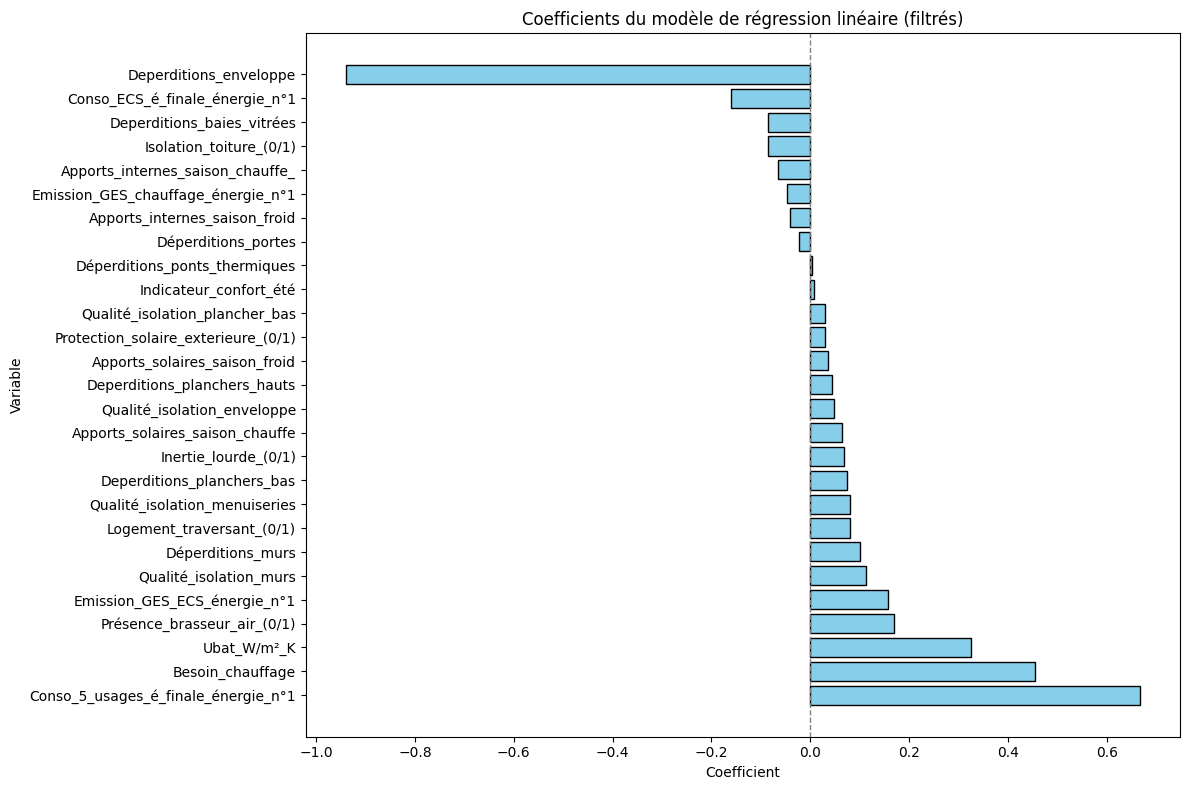

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

# Charger le tableau des données
# Assurez-vous que `correlation_means_df` est votre DataFrame final
data = correlation_means_df

# Filtrer ou trier les données si nécessaire
data = data.sort_values(by='Coefficient', ascending=False)

# Création du graphique
plt.figure(figsize=(12, 8))
bars = plt.barh(data['Variable'], data['Coefficient'], color='skyblue', edgecolor='black')

# Ajouter une ligne verticale pour la valeur zéro
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Configurations du graphique
plt.title("Coefficients du modèle de régression linéaire (filtrés)")
plt.xlabel("Coefficient")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


In [70]:
# IDENTIFICATION DES VARIABLES TROP CORRELEES

import re

data_corel = pd.read_excel('correlation_coef_vif_reg3.xlsx', sheet_name='Sheet1')

# Fonction pour extraire nom de variable et correl
def extract_correlations(correlation_column):
    correlations = []
    for entry in correlation_column.dropna():
        match = re.findall(r"(.+?) \(([\d.]+)\)", entry)
        if match:
            correlations.extend([(var.strip(), float(coeff)) for var, coeff in match])
    return correlations

# Extraire les correls
correlation_columns = ['Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation']
all_correlations = []

for column in correlation_columns:
    all_correlations.extend(extract_correlations(data_corel[column]))

# Organiser en groupe cohérent de vraiables ayant des corels > 0.8
strong_correlations = [(data_corel['Variable'][i], pair[0], pair[1])
                       for i, column in enumerate(correlation_columns)
                       for pair in extract_correlations(data_corel[column]) if pair[1] > 0.75]
strong_corr_df = pd.DataFrame(strong_correlations, columns=['Variable', 'Correlated With', 'Correlation'])
strong_corr_df.sort_values(by='Correlation', ascending=False, inplace=True)


# Exportation
strong_corr_df.to_excel('strong_corr_df_reg3.xlsx', index=False)

strong_corr_df.head(5)


,Variable,Correlated With,Correlation
4,Ubat_W/m²_K,Deperditions_enveloppe,0.95
6,Ubat_W/m²_K,Besoin_chauffage,0.95
5,Ubat_W/m²_K,Deperditions_enveloppe,0.90
14,Conso_5_usages_é_finale_énergie_n°1,Déperditions_murs,0.90
13,Conso_5_usages_é_finale_énergie_n°1,Besoin_chauffage,0.89


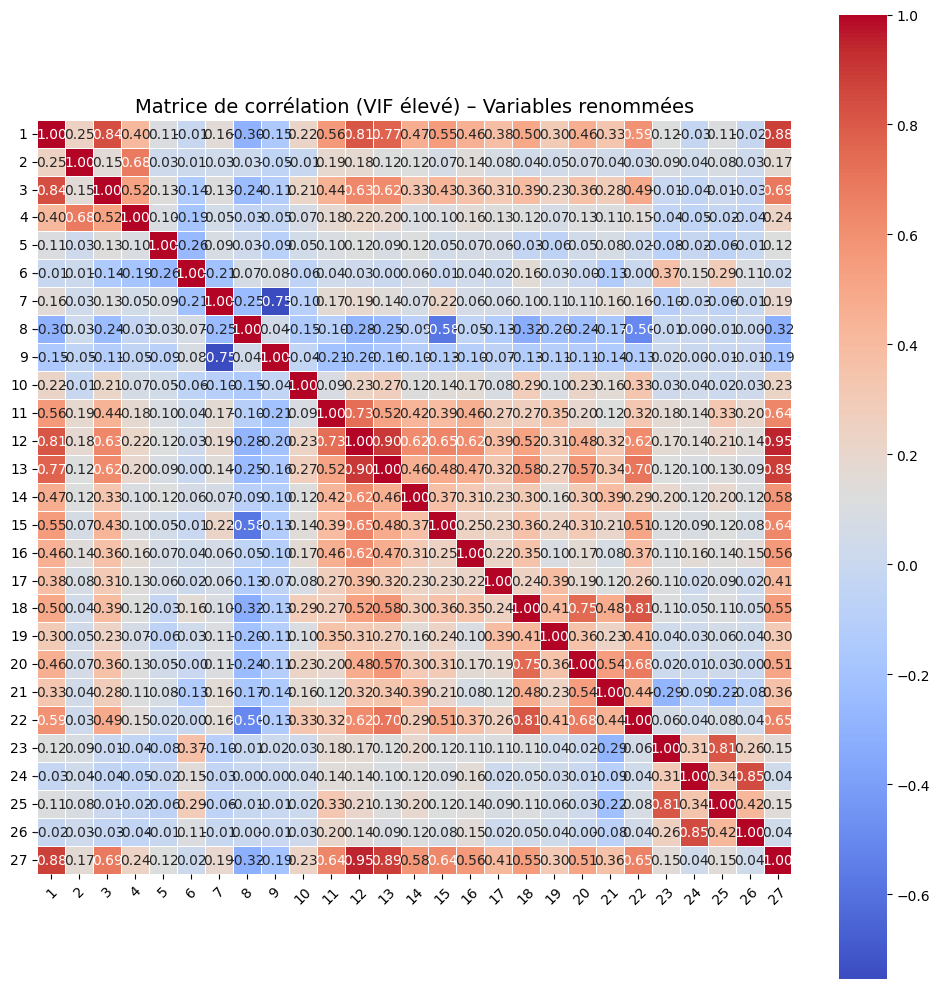


=== Correspondance : label numérique -> nom de variable original ===
1: Conso_5_usages_é_finale_énergie_n°1
2: Conso_ECS_é_finale_énergie_n°1
3: Emission_GES_chauffage_énergie_n°1
4: Emission_GES_ECS_énergie_n°1
5: Logement_traversant_(0/1)
6: Présence_brasseur_air_(0/1)
7: Indicateur_confort_été
8: Isolation_toiture_(0/1)
9: Protection_solaire_exterieure_(0/1)
10: Inertie_lourde_(0/1)
11: Deperditions_baies_vitrées
12: Deperditions_enveloppe
13: Déperditions_murs
14: Deperditions_planchers_bas
15: Deperditions_planchers_hauts
16: Déperditions_ponts_thermiques
17: Déperditions_portes
18: Qualité_isolation_enveloppe
19: Qualité_isolation_menuiseries
20: Qualité_isolation_murs
21: Qualité_isolation_plancher_bas
22: Ubat_W/m²_K
23: Apports_internes_saison_chauffe_
24: Apports_internes_saison_froid
25: Apports_solaires_saison_chauffe
26: Apports_solaires_saison_froid
27: Besoin_chauffage


In [71]:

import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Définition du seuil de VIF
threshold_vif = 1
high_vif_variables = vif_data[
    vif_data["VIF"] >= threshold_vif
]["Variable"].tolist()


#matrice
if len(high_vif_variables) > 1:

    sub_corr_matrix = X_numeric[high_vif_variables].corr()

    #{nom_original: "1", "2", ...}
    short_names_map = {
        var: str(idx + 1) for idx, var in enumerate(high_vif_variables)
    }

    # Renommer l'index et les colonnes de la sous-matrice de corrélation
    sub_corr_matrix_renamed = sub_corr_matrix.rename(
        index=short_names_map,
        columns=short_names_map
    )

    plt.figure(figsize=(10, 10))
    sns.heatmap(
        sub_corr_matrix_renamed,
        annot=True,
        cmap="coolwarm",
        linewidths=0.5,
        fmt=".2f",
        square=True
    )
    plt.title("Matrice de corrélation (VIF élevé) – Variables renommées", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\n=== Correspondance : label numérique -> nom de variable original ===")
    for original_var, short_name in short_names_map.items():
        print(f"{short_name}: {original_var}")

else:
    print("\nAucune variable avec un VIF supérieur ou égal au seuil spécifié.")



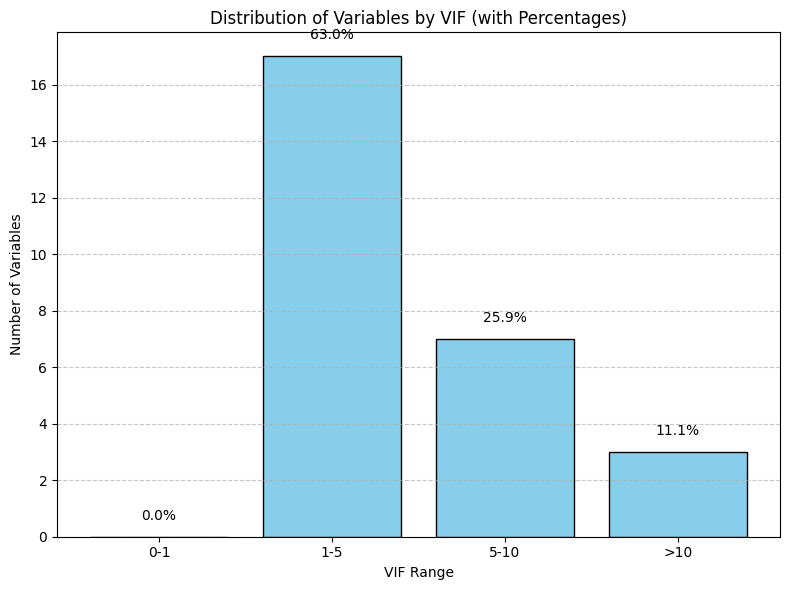

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Définir les bins pour catégoriser les VIF
bins = [0, 1, 5, 10, np.inf]  # Par exemple : 0-1, 1-5, 5-10, >10
labels = ["0-1", "1-5", "5-10", ">10"]

# Ajouter une colonne 'bin' dans le DataFrame vif_data
vif_data["VIF Bin"] = pd.cut(vif_data["VIF"], bins=bins, labels=labels, right=False)

# Compter le nombre de variables dans chaque bin
vif_counts = vif_data["VIF Bin"].value_counts().sort_index()

# Calculer les pourcentages
total_variables = vif_data.shape[0]
vif_percentages = (vif_counts / total_variables) * 100

# Tracer un graphique
plt.figure(figsize=(8, 6))
bars = plt.bar(vif_counts.index, vif_counts, color="skyblue", edgecolor="black")

# Ajouter les étiquettes des pourcentages
for bar, percentage in zip(bars, vif_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{percentage:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Ajouter les titres et axes
plt.xlabel("VIF Range")
plt.ylabel("Number of Variables")
plt.title("Distribution of Variables by VIF (with Percentages)")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### SUPPRESSION DES VARIABLES TRES COLINEAIRES

In [73]:
variables_colinear = ["Deperditions_enveloppe","Conso_5_usages_é_finale_énergie_n°1"
]


retrieved_rows = correlation_means_df.loc[correlation_means_df['Variable'].isin(variables_colinear)]
retrieved_rows

,Variable,Coefficient,correl_y,VIF,Mean Correlation,Top 1 Correlation,Top 2 Correlation,Top 3 Correlation
0,Conso_5_usages_é_finale_énergie_n°1,0.667334,0.681736,8.954091,0.375676,Besoin_chauffage (0.88),Emission_GES_chauffage_énergie_n°1 (0.84),Deperditions_enveloppe (0.81)
11,Deperditions_enveloppe,-0.940088,0.434817,94.566818,0.410448,Besoin_chauffage (0.95),Déperditions_murs (0.90),Conso_5_usages_é_finale_énergie_n°1 (0.81)


In [74]:
columns_to_drop = ["Deperditions_enveloppe","Conso_5_usages_é_finale_énergie_n°1"
]

data_cleaned4 = data_cleaned3.drop(columns=columns_to_drop)
data_cleaned4.head()

,conso_nrj_m2_par_an,Conso_ECS_é_finale_énergie_n°1,Emission_GES_chauffage_énergie_n°1,Emission_GES_ECS_énergie_n°1,Logement_traversant_(0/1),Présence_brasseur_air_(0/1),Indicateur_confort_été,Isolation_toiture_(0/1),Protection_solaire_exterieure_(0/1),Inertie_lourde_(0/1),...,Qualité_isolation_enveloppe,Qualité_isolation_menuiseries,Qualité_isolation_murs,Qualité_isolation_plancher_bas,Ubat_W/m²_K,Apports_internes_saison_chauffe_,Apports_internes_saison_froid,Apports_solaires_saison_chauffe,Apports_solaires_saison_froid,Besoin_chauffage
0,0.685970,1.130888,0.342374,1.442292,1,0,-0.643741,1.0,1,0,...,1.052854,-0.624197,0.910740,0.861331,0.203458,-0.490504,-0.149487,-0.374362,-0.120456,0.127881
1,-0.963054,0.845745,-0.514802,-0.320722,1,0,-2.139149,1.0,1,1,...,-0.757167,-0.624197,-0.854819,-0.065890,-0.663287,-0.489370,-0.149487,-0.374145,-0.120456,-0.412381
2,-0.215804,0.372723,-0.444818,-0.437934,1,0,-2.139149,1.0,1,1,...,1.052854,0.451096,0.910740,-0.065890,0.107153,1.914207,2.891435,1.537913,1.688816,0.569414
3,-1.159091,-0.982610,-0.350016,-0.773197,1,0,0.851667,1.0,0,0,...,1.052854,0.451096,0.910740,0.861331,1.816568,-0.487584,-0.143373,-0.373610,-0.118341,2.724268
4,-0.236561,0.267248,-0.394775,-0.463981,1,0,-0.643741,1.0,1,0,...,1.052854,1.526388,-0.854819,-0.065890,0.131229,-0.490380,-0.149487,-0.373719,-0.120456,0.161126


## REGRESSION 4

In [110]:
# MODELE DE REGRESSION LINEAIRE

columns_to_drop = ["Besoin_chauffage","Logement_traversant_(0/1)","Conso_ECS_é_finale_énergie_n°1","Emission_GES_ECS_énergie_n°1"]
data_cleaned5 = data_cleaned4.drop(columns=columns_to_drop)
data_cleaned5.head()

X = data_cleaned5.drop(columns=["conso_nrj_m2_par_an"])
y = data_cleaned5["conso_nrj_m2_par_an"]

X4_train, X4_test, y4_train, y4_test = train_test_split(X, y, test_size=0.2, random_state=42)

model4 = LinearRegression()
model4.fit(X4_train, y4_train)

y4_pred = model4.predict(X4_test)


# EVALUATION
mse_4 = mean_squared_error(y4_test, y4_pred)
r2_4 = r2_score(y4_test, y4_pred)

print(f"Mean Squared Error: {mse_4}")
print(f"R-squared: {r2_4}")


# COEFS
coefficients4 = pd.DataFrame(model4.coef_, X.columns, columns=['Coefficient'])

Mean Squared Error: 0.34325891846441964
R-squared: 0.6570408722378018


--> baisse du R2, on a perdu de l'info mais peut etre que le modele overfit moins

In [111]:
top_N = 10

top_abs = coefficients4.reindex(coefficients4['Coefficient'].abs().sort_values(ascending=False).index).head(top_N)
print("Top coefficients par valeur absolue :")
top_abs




Top coefficients par valeur absolue :


,Coefficient
Emission_GES_chauffage_énergie_n°1,0.444484
Ubat_W/m²_K,0.397720
Présence_brasseur_air_(0/1),0.217521
Deperditions_baies_vitrées,-0.200213
Apports_internes_saison_froid,-0.127924
Qualité_isolation_murs,0.122520
Isolation_toiture_(0/1),-0.111557
Qualité_isolation_menuiseries,0.076238
Déperditions_ponts_thermiques,-0.069989
Qualité_isolation_plancher_bas,0.056060


In [112]:
# COLINEARITE DES VARIABLES

X_numeric = X.apply(pd.to_numeric, errors='coerce')

# Remplir les valeurs manquantes avec la moyenne de chaque colonne
X_numeric = X_numeric.fillna(X_numeric.mean())


# Calculer le VIF : Variance Inflation Factor
# VIF = 1 : Aucune corrélation entre cette variable et les autres variables explicatives.
# 1 < VIF < 5 : Corrélation modérée, généralement acceptable.
# VIF ≥ 5 : Corrélation élevée, potentiellement problématique.
# VIF ≥ 10 : Corrélation très élevée, indiquant une multicolinéarité sévère

vif_data = pd.DataFrame()
vif_data["Variable"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print(vif_data)

                               Variable       VIF
0    Emission_GES_chauffage_énergie_n°1  1.877010
1           Présence_brasseur_air_(0/1)  1.428613
2                Indicateur_confort_été  2.144310
3               Isolation_toiture_(0/1)  3.352552
4   Protection_solaire_exterieure_(0/1)  3.764224
5                  Inertie_lourde_(0/1)  1.448440
6            Deperditions_baies_vitrées  2.249648
7                     Déperditions_murs  3.325676
8            Deperditions_planchers_bas  1.765088
9          Deperditions_planchers_hauts  1.818985
10        Déperditions_ponts_thermiques  1.637197
11                  Déperditions_portes  1.314843
12          Qualité_isolation_enveloppe  4.544183
13        Qualité_isolation_menuiseries  1.592059
14               Qualité_isolation_murs  2.954164
15       Qualité_isolation_plancher_bas  2.063957
16                          Ubat_W/m²_K  5.027786
17     Apports_internes_saison_chauffe_  3.986324
18        Apports_internes_saison_froid  3.982265


In [113]:
# CREATION D'UN GRAND TABLEAU D'ANALYSE DES VARIABLES
# 'Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation'


# Calculer la matrice de corrélation des variables explicatives
correlation_matrix = X.corr()

# Dictionnaires permettant de stocker les valeurs pour calculer 'Mean Correlation'
correlation_sums = {col: 0 for col in correlation_matrix.columns}
correlation_counts = {col: 0 for col in correlation_matrix.columns}

# Parcourir la matrice de corrélation pour extraire les couples de variables et leurs coefficients de corrélation
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        correlation = correlation_matrix.iloc[i, j]

        # Vérifier si la corrélation n'est pas NaN
        if not pd.isna(correlation):
            # Ajouter la corrélation aux sommes et incrémenter les compteurs
            correlation_sums[var1] += abs(correlation)
            correlation_sums[var2] += abs(correlation)
            correlation_counts[var1] += 1
            correlation_counts[var2] += 1

# Calculer la corrélation moyenne pour chaque variable
correlation_means = {var: correlation_sums[var] / correlation_counts[var] for var in correlation_sums if correlation_counts[var] > 0}
correlation_means_df = pd.DataFrame(list(correlation_means.items()), columns=['Variable', 'Mean Correlation'])

# Ajouter les top3 des variables corrélées à la variable var
top_correlations = {var: [] for var in correlation_matrix.columns}
for var in correlation_matrix.columns:
    sorted_correlations = correlation_matrix[var].abs().sort_values(ascending=False)
    top_3 = sorted_correlations.index[1:4]      # Exclure la corrélation avec elle-même : la premiere est la plus elevee, elle vaut 1, c est la correl de la variable avec elle meme
    top_correlations[var] = [f"{v} ({correlation_matrix.loc[var, v]:.2f})" for v in top_3]

correlation_means_df['Top 1 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][0])
correlation_means_df['Top 2 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][1])
correlation_means_df['Top 3 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][2])


# Coefs de la regression lineaire
coefficients4 = pd.DataFrame(model4.coef_, X.columns, columns=['Coefficient'])
correlation_means_df = correlation_means_df.merge(coefficients4, left_on='Variable', right_index=True)

# Correl avec y
correlations_df = correlations_with_y.reset_index()
correlations_df.columns = ["Variable", "correl_y"]
correlation_means_df = correlation_means_df.merge(correlations_df, on='Variable')

# Coef VIF
correlation_means_df = correlation_means_df.merge(vif_data, on='Variable')


# Traitement du tableau final
cols = ['Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation']
correlation_means_df = correlation_means_df[cols]
correlation_means_df = correlation_means_df.sort_values(by='correl_y', ascending=False)

# Exportation
correlation_means_df.to_excel('correlation_coef_vif_reg4.xlsx', index=False)


correlation_means_df.head(15)

,Variable,Coefficient,correl_y,VIF,Mean Correlation,Top 1 Correlation,Top 2 Correlation,Top 3 Correlation
16,Ubat_W/m²_K,0.397720,0.694644,5.027786,0.332298,Qualité_isolation_enveloppe (0.81),Déperditions_murs (0.70),Qualité_isolation_murs (0.68)
12,Qualité_isolation_enveloppe,0.050733,0.614777,4.544183,0.312403,Ubat_W/m²_K (0.81),Qualité_isolation_murs (0.75),Déperditions_murs (0.58)
0,Emission_GES_chauffage_énergie_n°1,0.444484,0.603011,1.877010,0.257588,Déperditions_murs (0.62),Ubat_W/m²_K (0.49),Deperditions_baies_vitrées (0.44)
14,Qualité_isolation_murs,0.122520,0.585688,2.954164,0.258713,Qualité_isolation_enveloppe (0.75),Ubat_W/m²_K (0.68),Déperditions_murs (0.57)
7,Déperditions_murs,-0.043495,0.521557,3.325676,0.329139,Ubat_W/m²_K (0.70),Emission_GES_chauffage_énergie_n°1 (0.62),Qualité_isolation_enveloppe (0.58)
15,Qualité_isolation_plancher_bas,0.056060,0.423037,2.063957,0.233202,Qualité_isolation_murs (0.54),Qualité_isolation_enveloppe (0.48),Ubat_W/m²_K (0.44)
9,Deperditions_planchers_hauts,-0.017008,0.374236,1.818985,0.262646,Isolation_toiture_(0/1) (-0.58),Ubat_W/m²_K (0.51),Déperditions_murs (0.48)
13,Qualité_isolation_menuiseries,0.076238,0.340532,1.592059,0.193266,Ubat_W/m²_K (0.41),Qualité_isolation_enveloppe (0.41),Déperditions_portes (0.39)
5,Inertie_lourde_(0/1),0.048858,0.261138,1.448440,0.133162,Ubat_W/m²_K (0.33),Qualité_isolation_enveloppe (0.29),Déperditions_murs (0.27)
8,Deperditions_planchers_bas,0.020509,0.241051,1.765088,0.232517,Déperditions_murs (0.46),Deperditions_baies_vitrées (0.42),Qualité_isolation_plancher_bas (0.39)


In [114]:
# IDENTIFICATION DES VARIABLES TROP CORRELEES

import re

data_corel = pd.read_excel('correlation_coef_vif_reg4.xlsx', sheet_name='Sheet1')

# Fonction pour extraire nom de variable et correl
def extract_correlations(correlation_column):
    correlations = []
    for entry in correlation_column.dropna():
        match = re.findall(r"(.+?) \(([\d.]+)\)", entry)
        if match:
            correlations.extend([(var.strip(), float(coeff)) for var, coeff in match])
    return correlations

# Extraire les correls
correlation_columns = ['Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation']
all_correlations = []

for column in correlation_columns:
    all_correlations.extend(extract_correlations(data_corel[column]))

# Organiser en groupe cohérent de vraiables ayant des corels > 0.8
strong_correlations = [(data_corel['Variable'][i], pair[0], pair[1])
                       for i, column in enumerate(correlation_columns)
                       for pair in extract_correlations(data_corel[column]) if pair[1] > 0.75]
strong_corr_df = pd.DataFrame(strong_correlations, columns=['Variable', 'Correlated With', 'Correlation'])
strong_corr_df.sort_values(by='Correlation', ascending=False, inplace=True)


# Exportation
strong_corr_df.to_excel('strong_corr_df_reg4.xlsx', index=False)

strong_corr_df.head(5)


,Variable,Correlated With,Correlation
4,Ubat_W/m²_K,Apports_internes_saison_froid,0.85
5,Ubat_W/m²_K,Apports_solaires_saison_froid,0.85
0,Ubat_W/m²_K,Qualité_isolation_enveloppe,0.81
1,Ubat_W/m²_K,Ubat_W/m²_K,0.81
2,Ubat_W/m²_K,Apports_solaires_saison_chauffe,0.81


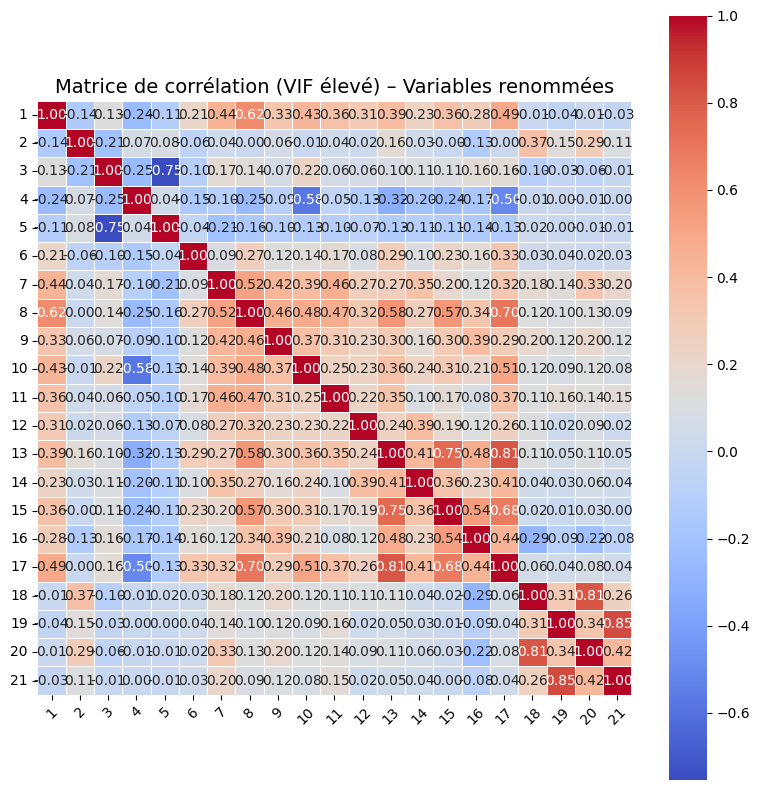


=== Correspondance : label numérique -> nom de variable original ===
1: Emission_GES_chauffage_énergie_n°1
2: Présence_brasseur_air_(0/1)
3: Indicateur_confort_été
4: Isolation_toiture_(0/1)
5: Protection_solaire_exterieure_(0/1)
6: Inertie_lourde_(0/1)
7: Deperditions_baies_vitrées
8: Déperditions_murs
9: Deperditions_planchers_bas
10: Deperditions_planchers_hauts
11: Déperditions_ponts_thermiques
12: Déperditions_portes
13: Qualité_isolation_enveloppe
14: Qualité_isolation_menuiseries
15: Qualité_isolation_murs
16: Qualité_isolation_plancher_bas
17: Ubat_W/m²_K
18: Apports_internes_saison_chauffe_
19: Apports_internes_saison_froid
20: Apports_solaires_saison_chauffe
21: Apports_solaires_saison_froid


In [115]:

# Définition du seuil de VIF
threshold_vif = 1
high_vif_variables = vif_data[
    vif_data["VIF"] >= threshold_vif
]["Variable"].tolist()


#matrice
if len(high_vif_variables) > 1:

    sub_corr_matrix = X_numeric[high_vif_variables].corr()

    #{nom_original: "1", "2", ...}
    short_names_map = {
        var: str(idx + 1) for idx, var in enumerate(high_vif_variables)
    }

    # Renommer l'index et les colonnes de la sous-matrice de corrélation
    sub_corr_matrix_renamed = sub_corr_matrix.rename(
        index=short_names_map,
        columns=short_names_map
    )

    plt.figure(figsize=(8, 8))
    sns.heatmap(
        sub_corr_matrix_renamed,
        annot=True,
        cmap="coolwarm",
        linewidths=0.5,
        fmt=".2f",
        square=True
    )
    plt.title("Matrice de corrélation (VIF élevé) – Variables renommées", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\n=== Correspondance : label numérique -> nom de variable original ===")
    for original_var, short_name in short_names_map.items():
        print(f"{short_name}: {original_var}")

else:
    print("\nAucune variable avec un VIF supérieur ou égal au seuil spécifié.")



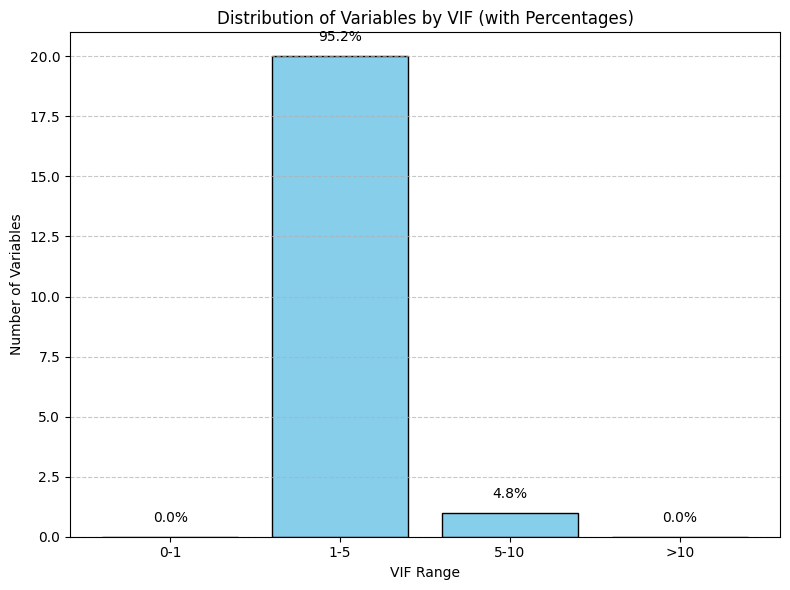

In [116]:
import matplotlib.pyplot as plt
import numpy as np

# Définir les bins pour catégoriser les VIF
bins = [0, 1, 5, 10, np.inf]  # Par exemple : 0-1, 1-5, 5-10, >10
labels = ["0-1", "1-5", "5-10", ">10"]

# Ajouter une colonne 'bin' dans le DataFrame vif_data
vif_data["VIF Bin"] = pd.cut(vif_data["VIF"], bins=bins, labels=labels, right=False)

# Compter le nombre de variables dans chaque bin
vif_counts = vif_data["VIF Bin"].value_counts().sort_index()

# Calculer les pourcentages
total_variables = vif_data.shape[0]
vif_percentages = (vif_counts / total_variables) * 100

# Tracer un graphique
plt.figure(figsize=(8, 6))
bars = plt.bar(vif_counts.index, vif_counts, color="skyblue", edgecolor="black")

# Ajouter les étiquettes des pourcentages
for bar, percentage in zip(bars, vif_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{percentage:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Ajouter les titres et axes
plt.xlabel("VIF Range")
plt.ylabel("Number of Variables")
plt.title("Distribution of Variables by VIF (with Percentages)")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


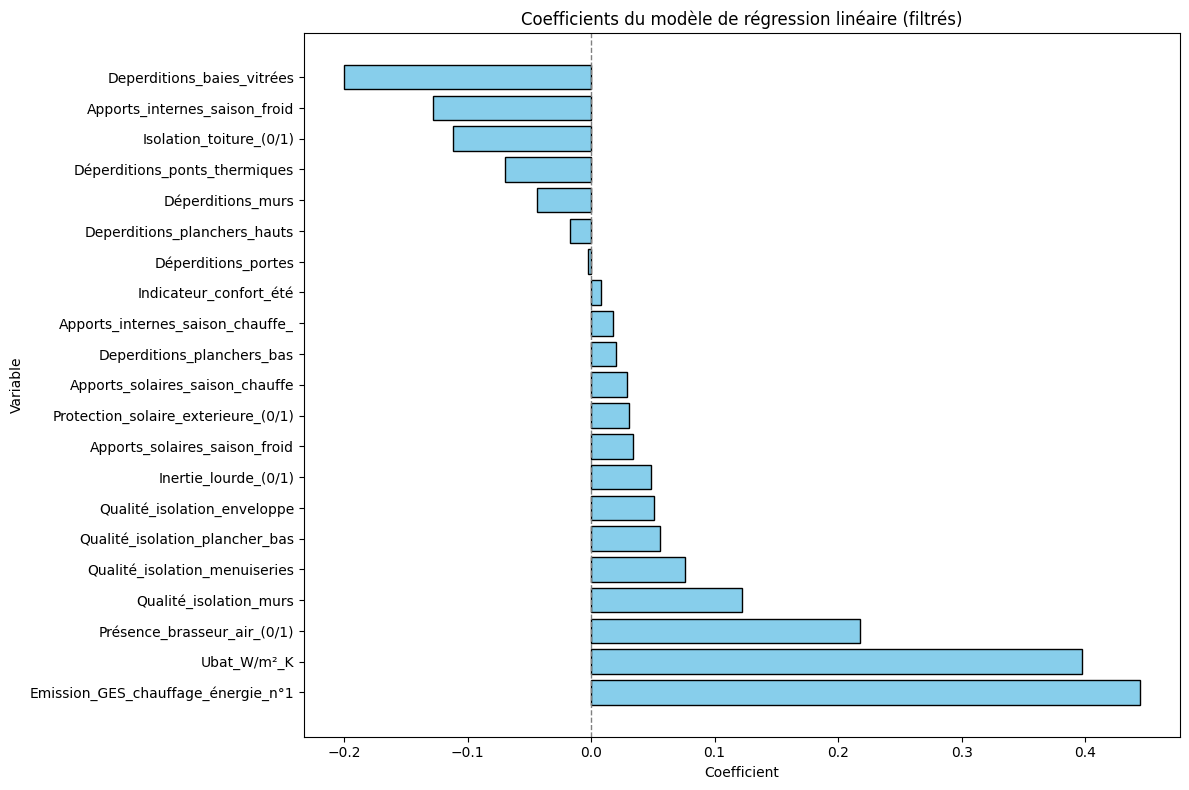

In [117]:
import matplotlib.pyplot as plt
import pandas as pd

# Charger le tableau des données
# Assurez-vous que `correlation_means_df` est votre DataFrame final
data = correlation_means_df

# Filtrer ou trier les données si nécessaire
data = data.sort_values(by='Coefficient', ascending=False)

# Création du graphique
plt.figure(figsize=(12, 8))
bars = plt.barh(data['Variable'], data['Coefficient'], color='skyblue', edgecolor='black')

# Ajouter une ligne verticale pour la valeur zéro
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Configurations du graphique
plt.title("Coefficients du modèle de régression linéaire (filtrés)")
plt.xlabel("Coefficient")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

## STABILITE

In [79]:
# REGULARISATION LASSO : pour éliminer des variables

# Utiliser LassoCV pour trouver les hyperparamètres optimaux
lasso2 = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
y_pred = lasso2.predict(X_test)

# Eval
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Meilleur alpha trouvé par LassoCV: {lasso2.alpha_}")

# Coefs
lasso_coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso2.coef_})

NameError: name 'X_train' is not defined

In [ ]:
# REGULARISATION ELASTICNET : pour supprimer moins de variables que Lasso et réduire les coefs afin de gérer la multicolinearite
# On espere garder un peu plus de variables

# Utiliser ElasticNetCV pour trouver les hyperparamètres optimaux
elastic_net2 = ElasticNetCV(cv=5, random_state=42).fit(X_train, y_train)
y_pred = elastic_net2.predict(X_test)

# Évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Meilleur alpha trouvé par ElasticNetCV: {elastic_net2.alpha_}")
print(f"Meilleur l1_ratio trouvé par ElasticNetCV: {elastic_net2.l1_ratio_}")

# Coefs
elastic_net_coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': elastic_net2.coef_})

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score


best_alpha_lasso = lasso2.alpha_
best_alpha_elastic = elastic_net2.alpha_
best_l1_ratio_elastic = elastic_net.l1_ratio_

#modele
models = {
    "OLS": LinearRegression(),
    "Lasso": Lasso(alpha=best_alpha_lasso, random_state=42),
    "ElasticNet": ElasticNet(alpha=best_alpha_elastic, l1_ratio=best_l1_ratio_elastic, random_state=42)
}


kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_results = {}
r2_results = {}
coefficients = {name: [] for name in models.keys()}

#  validation croisée
for train_idx, test_idx in kf.split(X):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    for name, model in models.items():

        model.fit(X_train_cv, y_train_cv)
        coefficients[name].append(model.coef_)

        y_pred = model.predict(X_test_cv)
        mse_results.setdefault(name, []).append(mean_squared_error(y_test_cv, y_pred))
        r2_results.setdefault(name, []).append(r2_score(y_test_cv, y_pred))


summary = []
for name in models.keys():
    mse_mean = np.mean(mse_results[name])
    mse_std = np.std(mse_results[name])
    r2_mean = np.mean(r2_results[name])
    r2_std = np.std(r2_results[name])
    summary.append({
        "Model": name,
        "MSE Mean": mse_mean,
        "MSE Std": mse_std,
        "R² Mean": r2_mean,
        "R² Std": r2_std
    })

summary_df = pd.DataFrame(summary)

coefficients_std = {}
for name, coefs in coefficients.items():
    coefs_array = np.array(coefs)
    coefficients_std[name] = coefs_array.std(axis=0)


stability_df = pd.DataFrame({
    "Feature": X.columns,
    "Std_OLS": coefficients_std["OLS"],
    "Std_Lasso": coefficients_std["Lasso"],
    "Std_ElasticNet": coefficients_std["ElasticNet"]
}).sort_values(by="Std_OLS", ascending=False)


print("=== Résumé des performances (MSE et R²) ===")
print(summary_df)

print("\n=== Stabilité des coefficients ===")
print(stability_df)


mean_std = {
    name: np.mean(std) for name, std in coefficients_std.items()
}
print("\n=== Moyenne de l'écart-type des coefficients ===")
for name, mean_std_value in mean_std.items():
    print(f"{name} : {mean_std_value:.4f}")



## Graph utiles

In [118]:
from sklearn.utils import resample
import numpy as np

# Fonction pour calculer la stabilité
def calculate_stability(model, X_test, y_test, n_iterations=100):
    stabilities = []
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X_test, y_test, random_state=42)
        y_pred_resampled = model.predict(X_resampled)
        stability_mse = mean_squared_error(y_resampled, y_pred_resampled)
        stabilities.append(stability_mse)
    return np.std(stabilities)

# Calcul de la stabilité pour chaque modèle
stability_1 = calculate_stability(model, X1_test, y1_test)
stability_2 = calculate_stability(model2, X2_test, y2_test)
stability_3 = calculate_stability(model3, X3_test, y3_test)
stability_4 = calculate_stability(model4, X4_test, y4_test)

# Résumé des résultats
results = [
    {"Model": "Model 1", "MSE": mse_1, "R2": r2_1, "Stability": stability_1},
    {"Model": "Model 2", "MSE": mse_2, "R2": r2_2, "Stability": stability_2},
    {"Model": "Model 3", "MSE": mse_3, "R2": r2_3, "Stability": stability_3},
    {"Model": "Model 4", "MSE": mse_4, "R2": r2_4, "Stability": stability_4},
]

print(results)



[{'Model': 'Model 1', 'MSE': 0.017651752971541926, 'R2': 0.9823636634710736, 'Stability': 3.3306690738754696e-16}, {'Model': 'Model 2', 'MSE': 0.22748901413913386, 'R2': 0.7727096670534817, 'Stability': 5.551115123125783e-17}, {'Model': 'Model 3', 'MSE': 0.23515803020197384, 'R2': 0.7650473488492759, 'Stability': 2.7755575615628914e-17}, {'Model': 'Model 4', 'MSE': 0.34325891846441964, 'R2': 0.6570408722378018, 'Stability': 0.0}]


In [119]:
# Ajouter le nombre de variables pour chaque modèle
num_variables_1 = X1_train.shape[1]
num_variables_2 = X2_train.shape[1]
num_variables_3 = X3_train.shape[1]
num_variables_4 = X4_train.shape[1]

# Mise à jour des résultats
results = [
    {"Model": "Model 1", "MSE": mse_1, "R2": r2_1, "Stability": stability_1, "Num Variables": num_variables_1},
    {"Model": "Model 2", "MSE": mse_2, "R2": r2_2, "Stability": stability_2, "Num Variables": num_variables_2},
    {"Model": "Model 3", "MSE": mse_3, "R2": r2_3, "Stability": stability_3, "Num Variables": num_variables_3},
    {"Model": "Model 4", "MSE": mse_4, "R2": r2_4, "Stability": stability_4, "Num Variables": num_variables_4},
]


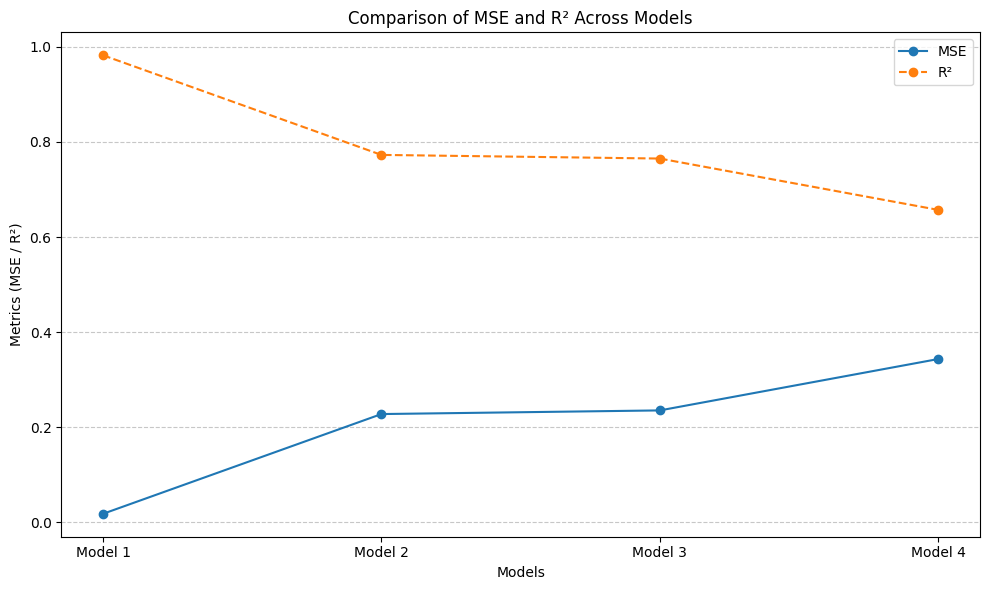

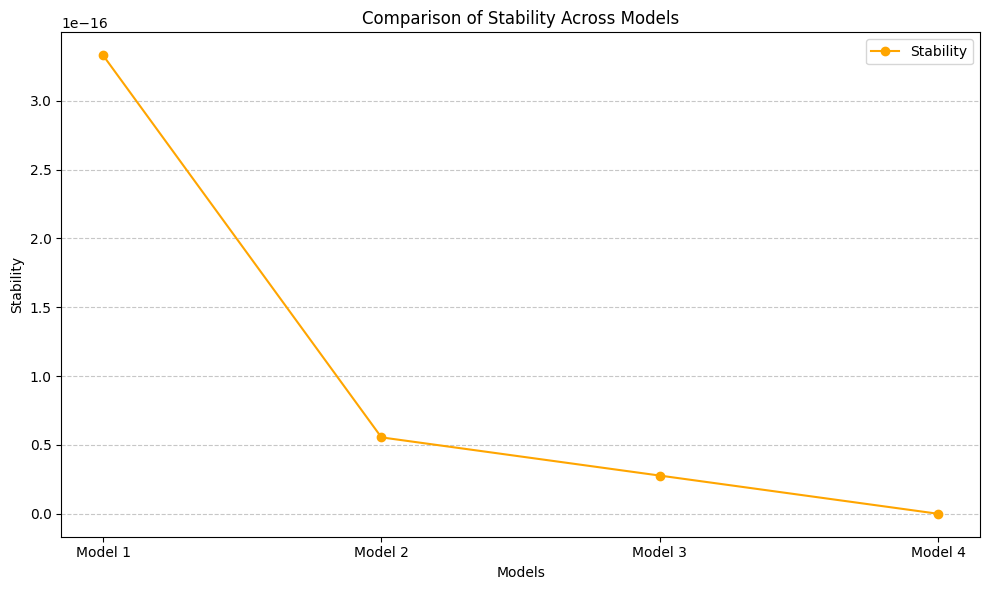

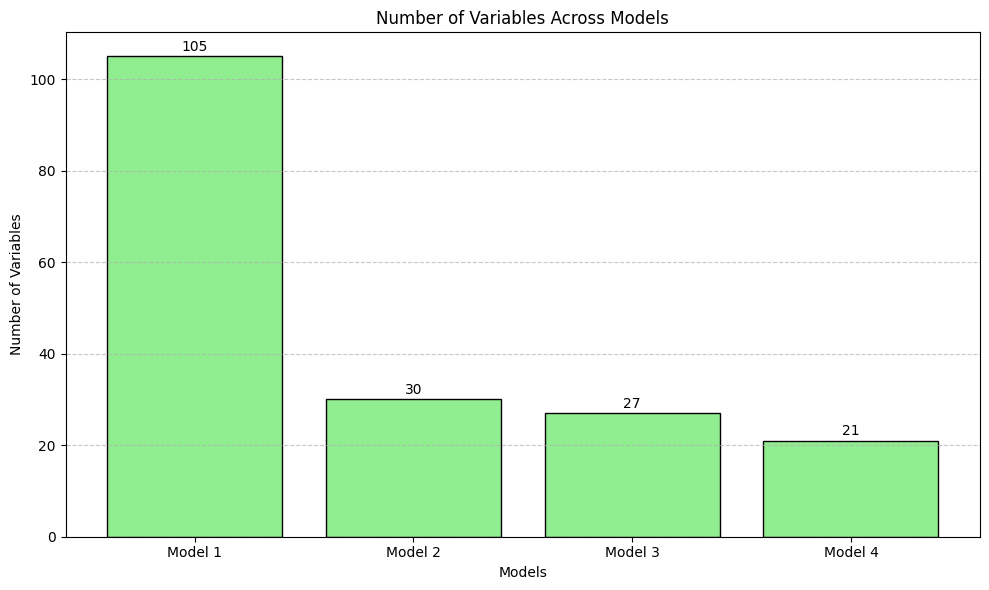

In [120]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Graphique 1 : MSE et R²
plt.figure(figsize=(10, 6))
plt.plot(results_df["Model"], results_df["MSE"], label="MSE", marker="o", linestyle="-")
plt.plot(results_df["Model"], results_df["R2"], label="R²", marker="o", linestyle="--")

# Configurations du graphique 1
plt.xlabel("Models")
plt.ylabel("Metrics (MSE / R²)")
plt.title("Comparison of MSE and R² Across Models")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique 2 : Stabilité
plt.figure(figsize=(10, 6))
plt.plot(results_df["Model"], results_df["Stability"], label="Stability", marker="o", color="orange")

# Configurations du graphique 2
plt.xlabel("Models")
plt.ylabel("Stability")
plt.title("Comparison of Stability Across Models")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique 3 : Nombre de variables
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df["Model"], results_df["Num Variables"], color="lightgreen", edgecolor="black")

# Ajouter des étiquettes sur les barres
for bar, num in zip(bars, results_df["Num Variables"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{num}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Configurations du graphique 3
plt.xlabel("Models")
plt.ylabel("Number of Variables")
plt.title("Number of Variables Across Models")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
